# Imports

In [1]:
# Miscellaneous
import os
import sys
sys.path.append("..") # So it's possible to retrieve packages at a higher top level. (than the directory where the notebook is running)

# Own imports
from helpers.general_helpers import pretty_dict_json_dump, pretty_dict_json_load, join_path, get_path_components

# Define the common arguments and order in which to print the arguments to file.

In [11]:
main_arguments = {
    'ARGS_DESC_1': 'Training and evaluation related arguments.',
    # Training and evaluation related arguments.
    'max_num_epochs': 25,
    'batch_size'    : None,
    'accumulate_n_batch_grads': 1,
    'batch_size_eval': 15,
    'optimiser': 'adam',
    'learning_rate': None,
    'weight_decay': 0.0,
    'loss_function_name': None,
    'loss_debug': True,

    'ARGS_DESC_2': 'Parameters concerning the dataset.',
    # Parameters concerning the dataset.
    'dataset': 'UW_RE_UVA',
    'validation': True,
    'check_val_every_n_epoch': 1,
    'num_workers': 3,
    'masking_type': None,
    'dataset_type': None,
    'setting': None,
    'fold': None,
    'classes_descs_embed_file': 'ELMO_relations.hdf5',
    'ulbs_type': 'basic',

    'ARGS_DESC_3': 'Specific state related arguments.',
    # Specific state related arguments.
    'epoch_or_best': None,
    'keep_last_n_chekpoints': 1,
    'save_path': None,

    'ARGS_DESC_4': 'Parameters concerning the model.',
    # Parameters concerning the model.
    'model_name': None,
    'load_model_arch': None,
    'load_model_params_from_dict_file': None,
    'model_eval_metrics_dict_file': None,

    'ARGS_DESC_5': 'Performance arguments.',
    # Performance arguments.
    'cuda_device': None,#0,
    'server_scratch': None,#'Lisa',
}


settings = ['N', 'ZS-O', 'ZS-C', 'GZS-O', 'GZS-C']
num_shots = [1, 2, 5, 10] # This indicates the number of shots for the specific dataset type.
fs = lambda x: 'FS-' + str(x)
gfs = lambda x: 'GFS-' + str(x)
settings += [f(num_shot) for num_shot in num_shots for f in (fs, gfs)]
settings = {'DEBUG': ['N', 'ZS-O', 'ZS-C', 'GZS-O', 'GZS-C', 'FS-1', 'GFS-1'], 'HT': settings, 'final': settings}

# Define the number of folds, per dataset type.
num_folds = {'DEBUG': 2, 'HT': 5, 'final': 10}

dataset_type_names = {'DEBUG': 'DEBUG', 'HT': 'hyperparameter_tuning', 'final': 'final_evaluation'}


def save_main_arguments_to_file(main_arguments_config, path, model_type='ESIM_StS', config_id=0, supress_path=False):

    if (not supress_path):
        path += main_arguments['masking_type'] + '/' + main_arguments['setting'] + '/' + main_arguments['fold'] + '/'

    directory = os.path.dirname(path)
    if (not os.path.exists(directory)):
        os.makedirs(directory)

    with open(path + 'main_arguments.txt', 'w', encoding='utf-8') as f:
        for key in main_arguments_config:
            if (key.startswith('ARGS_DESC')):
                if (int(key[len('ARGS_DESC_'):]) > 1):
                    f.write('\n\n')
                f.write("# " + main_arguments_config[key] + '\n')
            else:
                if (main_arguments_config[key] is not None):
                    f.write('--' + key + '=' + str(main_arguments_config[key]) + '\n')
                else:
                    f.write('#--' + key + '=' + str(main_arguments_config[key]) + '\n')

### Baseline

In [13]:
model_type = 'Baseline_BiLSTM'
baseline_params = {
    "classes_descs_embed_file"   : 'ELMO_relations.hdf5',
    "word_embedding_size"        : 3072,
    "single_embedding_bilstm"    : None,
    "first_bilstm_hidden_size"   : None,
}

physical_batch_size = 128
physical_batch_size_eval = 512

main_arguments['loss_function_name'] = 'ce'
main_arguments['model_name'] = 'Baseline_BiLSTM'



fbhs  = [500]#[50, 100, 200, 300, 400, 500]

seb  = [True]#[True, False]
lr   = [0.001]#, 0.005, 0.01]
bs   = [128]


f1_hmf1 = True

dataset_type = 'final'
save_folder = 'final_evaluation'
masking_type = 'NER_masking'
if (dataset_type != 'DEBUG'):
    main_arguments['cuda_device'] = 0
#     main_arguments['server_scratch'] = 'Lisa'
main_arguments['max_num_epochs'] = 25
main_arguments['dataset_type'] = dataset_type_names[dataset_type]
main_arguments['masking_type'] = masking_type
    

config_id = 0
for _lr in lr:
    for _bs in bs:
        for _seb in seb:
            for fbhs_l_size in fbhs:
#                 path = join_path(['..', 'saved_models_states', save_folder, model_type, 'config_' + str(config_id)]) + os.sep
                path = '../saved_models_states/' + save_folder + '/' + model_type + '/config_' + str(config_id) + '/'

                directory = os.path.dirname(path)
                if (not os.path.exists(directory)):
                    os.makedirs(directory)

                baseline_params["single_embedding_bilstm"]   = _seb
                baseline_params["first_bilstm_hidden_size"]  = fbhs_l_size

                with open(path + 'params_dict.txt', 'w', encoding='utf-8') as f:
                    pretty_dict_json_dump(baseline_params, f)

                main_arguments['batch_size'] = _bs
                main_arguments['batch_size_eval'] = physical_batch_size_eval
                main_arguments['learning_rate'] = _lr
                main_arguments['load_model_params_from_dict_file'] = path + 'params_dict.txt'

                config_id += 1

                for setting in settings[dataset_type]:
                    for fold in range(num_folds[dataset_type]):
                        main_arguments['setting'] = setting
                        main_arguments['fold'] = str(fold)
                        if (setting == 'N' or setting.split('-')[0] == 'ZS'):
                            main_arguments['model_eval_metrics_dict_file'] = 'esim_sts_metrics_dict_N_ZS.txt'
                        elif (setting.split('-')[0] == 'GZS'):
                            main_arguments['model_eval_metrics_dict_file'] = 'esim_sts_metrics_dict_GZS.txt'
                        else:
                            if (setting[0] == 'G'):
                                main_arguments['model_eval_metrics_dict_file'] = 'esim_sts_metrics_dict_GFS.txt'
                            else:
                                main_arguments['model_eval_metrics_dict_file'] = 'esim_sts_metrics_dict_FS.txt'
                        main_arguments['save_path'] = path[3:] + main_arguments['masking_type'] + '/' + main_arguments['setting'] + '/'
                        main_arguments['save_path'] += main_arguments['fold'] + '/saved_states/'
                        save_main_arguments_to_file(main_arguments, path, config_id=config_id)
#                     main_arguments['batch_size']               = default_batch_size
#                     main_arguments['batch_size_eval']          = default_batch_size_eval
#                     main_arguments['accumulate_n_batch_grads'] = default_accumulate_n_batch_grads

print(config_id, config_id*55, config_id*55*10*10/(60*4*11))

1 55 2.0833333333333335


### Pre-trained embedding layers

In [4]:
model_type = 'Embedding_Layer'
embedding_layer_params = {
   "word_embedding_size"      : 3072,
   "first_bilstm_hidden_size" : None
}

physical_batch_size = 128

main_arguments['max_num_epochs'] = 5
main_arguments['dataset_type'] = 'non_DEBUG'
main_arguments['loss_function_name'] = 'mse'
main_arguments['model_name'] = 'embedding_layer'
main_arguments['dataset'] = 'UW_RE_UVA_EMBEDDING_LAYER_PRE_TRAIN'
main_arguments['validation'] = False
main_arguments['model_eval_metrics_dict_file'] = 'embedding_layer_metrics.txt'




fbhs  = [50, 100, 200]

lr   = [0.00001]
bs   = [128]


f1_hmf1 = True

save_folder = 'pretrained_embedding_layer'
masking_types = ['unmasked', 'sub_obj_masking', 'NER_masking']
main_arguments['cuda_device'] = 0
main_arguments['server_scratch'] = 'Lisa'
    

for _lr in lr:
    for _bs in bs:
        for fbhs_l_size in fbhs:
            path = '../saved_models_states/' + save_folder + '/' + str(fbhs_l_size) + '/'

            directory = os.path.dirname(path)
            if (not os.path.exists(directory)):
                os.makedirs(directory)

            embedding_layer_params["first_bilstm_hidden_size"]  = fbhs_l_size

            with open(path + 'params_dict.txt', 'w', encoding='utf-8') as f:
                pretty_dict_json_dump(embedding_layer_params, f)

            main_arguments['batch_size'] = _bs
            main_arguments['learning_rate'] = _lr
            main_arguments['load_model_params_from_dict_file'] = path + 'params_dict.txt'

            for masking_type in masking_types:
                main_arguments['masking_type'] = masking_type
                main_arguments['save_path'] = path[3:] + main_arguments['masking_type'] + '/saved_states/'
                save_main_arguments_to_file(main_arguments, path + main_arguments['masking_type'] + os.sep, supress_path=True)

### ESIM_StS

In [15]:
model_type = 'ESIM_StS'
esim_sts_params = {
    "classes_descs_embed_file"       : 'ELMO_relations.hdf5',
    "word_embedding_size"            : 3072,
    "pretrained_embedding_layer_path": None,
    "single_embedding_bilstm"        : None,
    "first_bilstm_hidden_size"       : None,
    "post_attention_size"            : None,
    "second_bilstm_hidden_size"      : None,
    "leakyReLU_negative_slope"       : None,
    "score_mlp_post_first_layer"     : {
        "layers_sizes"         : None,
        "activation_functions" : None,
    }
}

physical_batch_size = {
    50:  {'DEBUG': {'N': 5,   'ZS': 5,   'GZS': 5,   'FS': 5,   'GFS': 5},
          'HT'   : {'N': 128, 'ZS': 128, 'GZS': 128, 'FS': 128, 'GFS': 128},
          'final': {'N': 64,  'ZS': 64,  'GZS': 64,  'FS': 64,  'GFS': 64},
         },
    100: {'DEBUG': {'N': 5,   'ZS': 5,   'GZS': 5,   'FS': 5,   'GFS': 5},
          'HT'   : {'N': 128, 'ZS': 128, 'GZS': 128, 'FS': 128, 'GFS': 128},
          'final': {'N': 64,  'ZS': 64,  'GZS': 64,  'FS': 64,  'GFS': 64},
         },
    200: {'DEBUG': {'N': 5,  'ZS': 5,   'GZS': 5,   'FS': 5,  'GFS': 5},
          'HT'   : {'N': 64, 'ZS': 128, 'GZS': 128, 'FS': 64, 'GFS': 64},
          'final': {'N': 32, 'ZS': 64,  'GZS': 64,  'FS': 64, 'GFS': 64},
         },
}

physical_batch_size_eval = {
    50:  {'DEBUG': {'N': 5,  'ZS': 5,  'GZS': 5,  'FS': 5,  'GFS': 5},
          'HT'   : {'N': 15, 'ZS': 50, 'GZS': 25, 'FS': 50, 'GFS': 25},
          'final': {'N': 64, 'ZS': 64, 'GZS': 64, 'FS': 64, 'GFS': 64},
         },
    100: {'DEBUG': {'N': 5,  'ZS': 5,  'GZS': 5,  'FS': 5,  'GFS': 5},
          'HT'   : {'N': 8,  'ZS': 25, 'GZS': 10, 'FS': 25, 'GFS': 10},
          'final': {'N': 64, 'ZS': 64, 'GZS': 64, 'FS': 64, 'GFS': 64},
         },
    200: {'DEBUG': {'N': 5,  'ZS': 5,  'GZS': 5,  'FS': 5,  'GFS': 5},
          'HT'   : {'N': 5,  'ZS': 10, 'GZS': 8,  'FS': 10, 'GFS': 8},
          'final': {'N': 2,  'ZS': 4,  'GZS': 3,  'FS': 4,  'GFS': 3},
         },
}

main_arguments['max_num_epochs'] = 25
main_arguments['loss_function_name'] = 'ce'
main_arguments['model_name'] = 'esim_sts'



fbhs  = [200]#[50, 100, 200]
max_num_score_hidden_layers = 1

lrns = [0.075]#[0.025, 0.075]
pre_train_el = [False]#[True, False]
seb  = [True]#[True, False]
lr   = [0.001]#, 0.005, 0.01]
bs   = [128]#32, 64, 128]

f1_hmf1 = True

dataset_type = 'final'
save_folder = 'final_evaluation'
masking_type = 'NER_masking'
if (dataset_type != 'DEBUG'):
    main_arguments['cuda_device'] = 0
    #main_arguments['server_scratch'] = 'Lisa'
main_arguments['dataset_type'] = dataset_type_names[dataset_type]
main_arguments['masking_type'] = masking_type
    

config_id = 0
for _lr in lr:
    for _bs in bs:
        for pretrained_embedding_layer in pre_train_el:
            for _seb in seb:
                for _lrns in lrns:
                    for fbhs_l_size in fbhs:
                        pas = [fbhs_l_size]#[fbhs_l_size]#list(fbhs[:fbhs.index(fbhs_l_size)+1])
                        for pas_l_size in pas:
                            sbhs = [pas_l_size]#[pas_l_size]#list(pas[:pas.index(pas_l_size)+1])
                            for sbhs_l_size in sbhs:
                                f_l_sizes = [sbhs_l_size]#[sbhs_l_size]#list(sbhs[:sbhs.index(sbhs_l_size)+1])
                                for num_hidden_layers in range(1, max_num_score_hidden_layers + 1):
                                    for f_l_size in f_l_sizes:
                                        if (num_hidden_layers == 1):
                                            path = '../saved_models_states/' + save_folder + '/'
                                            path += model_type + '/config_' + str(config_id) + '/'

                                            directory = os.path.dirname(path)
                                            if (not os.path.exists(directory)):
                                                os.makedirs(directory)

                                            if (pretrained_embedding_layer):
                                                esim_sts_params["pretrained_embedding_layer_path"] = 'saved_models_states/pretrained_embedding_layer/'
                                                esim_sts_params["pretrained_embedding_layer_path"] += str(fbhs_l_size) + "/" + masking_type + "/saved_states"
                                            else:
                                                esim_sts_params["pretrained_embedding_layer_path"] = None
                                            esim_sts_params["single_embedding_bilstm"]   = _seb
                                            esim_sts_params["first_bilstm_hidden_size"]  = fbhs_l_size
                                            esim_sts_params["post_attention_size"]       = pas_l_size
                                            esim_sts_params["second_bilstm_hidden_size"] = sbhs_l_size
                                            esim_sts_params["leakyReLU_negative_slope"]  = _lrns
                                            esim_sts_params["score_mlp_post_first_layer"]["layers_sizes"] = [f_l_size, 1]
                                            esim_sts_params["score_mlp_post_first_layer"]["activation_functions"]  = [["leaky_relu", "negative_slope=" + str(_lrns)]]

                                            with open(path + 'params_dict.txt', 'w', encoding='utf-8') as f:
                                                pretty_dict_json_dump(esim_sts_params, f)

                                            main_arguments['batch_size'] = _bs
                                            main_arguments['learning_rate'] = _lr
                                            main_arguments['load_model_params_from_dict_file'] = path + 'params_dict.txt'

                                            config_id += 1

                                            for setting in settings[dataset_type]:
                                                default_batch_size               = main_arguments['batch_size']
                                                default_batch_size_eval          = main_arguments['batch_size_eval']
                                                default_accumulate_n_batch_grads = main_arguments['accumulate_n_batch_grads']
                                                if (main_arguments['batch_size'] > physical_batch_size[fbhs_l_size][dataset_type][setting.split('-')[0]]):
                                                    ratio = int(main_arguments['batch_size'] / physical_batch_size[fbhs_l_size][dataset_type][setting.split('-')[0]])
                                                    main_arguments['batch_size'] = physical_batch_size[fbhs_l_size][dataset_type][setting.split('-')[0]]
                                                    main_arguments['accumulate_n_batch_grads'] *= ratio
                                                main_arguments['batch_size_eval'] = physical_batch_size_eval[fbhs_l_size][dataset_type][setting.split('-')[0]]

                                                for fold in range(num_folds[dataset_type]):
                                                    main_arguments['setting'] = setting
                                                    main_arguments['fold'] = str(fold)
                                                    if (f1_hmf1):
                                                        if (setting == 'N' or setting.split('-')[0] == 'ZS'):
                                                            main_arguments['model_eval_metrics_dict_file'] = 'esim_sts_metrics_dict_N_ZS.txt'
                                                        elif (setting.split('-')[0] == 'GZS'):
                                                            main_arguments['model_eval_metrics_dict_file'] = 'esim_sts_metrics_dict_GZS.txt'
                                                        else:
                                                            if (setting[0] == 'G'):
                                                                main_arguments['model_eval_metrics_dict_file'] = 'esim_sts_metrics_dict_GFS.txt'
                                                            else:
                                                                main_arguments['model_eval_metrics_dict_file'] = 'esim_sts_metrics_dict_FS.txt'
                                                    else:
                                                        main_arguments['model_eval_metrics_dict_file'] = 'esim_sts_metrics.txt'
                                                    main_arguments['save_path'] = path[3:] + main_arguments['masking_type'] + '/' + main_arguments['setting'] + '/'
                                                    main_arguments['save_path'] += main_arguments['fold'] + '/saved_states/'
                                                    save_main_arguments_to_file(main_arguments, path, config_id=config_id)
                                                main_arguments['batch_size']               = default_batch_size
                                                main_arguments['batch_size_eval']          = default_batch_size_eval
                                                main_arguments['accumulate_n_batch_grads'] = default_accumulate_n_batch_grads

                                        if (num_hidden_layers == 2):
                                            s_l_sizes = list(f_l_sizes[:f_l_sizes.index(f_l_size)])
                                            for s_l_size in s_l_sizes:
                                                path = '../saved_models_states/' + save_folder + '/'
                                                path += model_type + '/config_' + str(config_id) + '/'

                                                directory = os.path.dirname(path)
                                                if (not os.path.exists(directory)):
                                                    os.makedirs(directory)

                                                esim_sts_params["single_embedding_bilstm"]   = _seb
                                                esim_sts_params["first_bilstm_hidden_size"]  = fbhs_l_size
                                                esim_sts_params["post_attention_size"]       = pas_l_size
                                                esim_sts_params["second_bilstm_hidden_size"] = sbhs_l_size
                                                esim_sts_params["leakyReLU_negative_slope"]  = _lrns
                                                esim_sts_params["score_mlp_post_first_layer"]["layers_sizes"] = [f_l_size, s_l_size, 1]
                                                esim_sts_params["score_mlp_post_first_layer"]["activation_functions"] = [["leaky_relu", "negative_slope=" + str(_lrns)]]*2

                                                with open(path + 'params_dict.txt', 'w', encoding='utf-8') as f:
                                                    pretty_dict_json_dump(esim_sts_params, f)

                                                main_arguments['batch_size'] = _bs
                                                main_arguments['learning_rate'] = _lr
                                                main_arguments['load_model_params_from_dict_file'] = path + 'params_dict.txt'

                                                config_id += 1

                                                for setting in settings[dataset_type]:
                                                    if (main_arguments['batch_size'] > physical_batch_size[fbhs_l_size][dataset_type][setting.split('-')[0]]):
                                                        ratio = int(main_arguments['batch_size'] / physical_batch_size[fbhs_l_size][dataset_type][setting.split('-')[0]])
                                                        main_arguments['batch_size'] = physical_batch_size[fbhs_l_size][dataset_type][setting.split('-')[0]]
                                                        main_arguments['accumulate_n_batch_grads'] *= ratio
                                                    main_arguments['batch_size_eval'] = physical_batch_size_eval[fbhs_l_size][dataset_type][setting.split('-')[0]]

                                                    for fold in range(num_folds[dataset_type]):

                                                        main_arguments['setting'] = setting
                                                        main_arguments['fold'] = str(fold)
                                                        if (f1_hmf1):
                                                            if (setting == 'N' or setting.split('-')[0] == 'ZS'):
                                                                main_arguments['model_eval_metrics_dict_file'] = 'esim_sts_metrics_dict_N_ZS.txt'
                                                            elif (setting.split('-')[0] == 'GZS'):
                                                                main_arguments['model_eval_metrics_dict_file'] = 'esim_sts_metrics_dict_GZS.txt'
                                                            else:
                                                                if (setting[0] == 'G'):
                                                                    main_arguments['model_eval_metrics_dict_file'] = 'esim_sts_metrics_dict_GFS.txt'
                                                                else:
                                                                    main_arguments['model_eval_metrics_dict_file'] = 'esim_sts_metrics_dict_FS.txt'
                                                        else:
                                                            main_arguments['model_eval_metrics_dict_file'] = 'esim_sts_metrics.txt'
                                                        main_arguments['save_path'] = path[3:] + main_arguments['masking_type'] + '/' + main_arguments['setting'] + '/'
                                                        main_arguments['save_path'] += main_arguments['fold'] + '/saved_states/'
                                                        save_main_arguments_to_file(main_arguments, path, config_id=config_id)

print(config_id, config_id*55, config_id*55*10*10/(60*4*11))

1 55 2.0833333333333335


## Now we evaluate the results and choose the best hyperparameter setting.

In [2]:
from helpers.trainer.metrics_manager import MetricsManager
import pandas as dolphins
import numpy as np

# Hyperparameter Tuning Plots

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from   matplotlib.lines import Line2D
import random
from   scipy.stats import ttest_ind
from   tkinter import Tk
import math

In [4]:
def round_down(num, divisor):
    return int(num - (num%divisor))

def round_up(num, divisor):
    return int(num + (num%divisor))

## Baseline

In [15]:
saved_states = '..' + os.sep + 'saved_models_states'
dataset_type = 'hyperparameter_tuning'
config_ids = list(range(12))
model_type = 'Baseline_BiLSTM'
experiment_type = 'sub_obj_masking'
settings = ['N', 'ZS-O', 'ZS-C', 'FS-1', 'FS-2', 'FS-5', 'FS-10', 'GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']
folds = list(range(5))

selection_metric = {'N': 'MacroF1', 'ZS': 'MacroF1', 'GZS': 'HarmonicMacroF1', 'FS': 'MacroF1', 'GFS': 'HarmonicMacroF1'}

In [16]:
dolphins_dataframe_dict_test = {}

for setting in settings:
    dolphins_dataframe_dict_test[setting] = {}
    for fold in folds:
        dolphins_dataframe_dict_test[setting][fold] = {}
        for config_id in config_ids:
            mma_path = join_path([saved_states, dataset_type, model_type, 'config_' + str(config_id), experiment_type, setting,
                                  str(fold), 'saved_states', 'MMa' + os.sep])
            last_epoch = max([int(file.split('.')[-2]) for file in os.listdir(mma_path) if file.endswith('.ckp')])

            mma = MetricsManager(None, None, None, None, None, None, None, None, None, just_MMa=True, 
                                 load_path=join_path(get_path_components(mma_path)[:-1]) + os.sep, load_epoch_or_best=last_epoch)
            dolphins_dataframe_dict_test[setting][fold][config_id] = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).epoch_history[-1]

In [17]:
df_test = dolphins.DataFrame.from_dict({(i,j): dolphins_dataframe_dict_test[i][j] 
                                   for i in dolphins_dataframe_dict_test.keys() 
                                   for j in dolphins_dataframe_dict_test[i].keys()},
                                  orient='columns')
df_test.index.set_names(['Configuration'], inplace=True)
df_test.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_mean = df_test.mean(axis=1, level=0)
def_test_std  = df_test.std(axis=1, level=0)
dolphins.concat([def_test_mean, def_test_std])

Setting,N,ZS-O,ZS-C,FS-1,FS-2,FS-5,FS-10,GZS-O,GZS-C,GFS-1,GFS-2,GFS-5,GFS-10
Configuration,,,,,,,,,,,,,
0,51.147891,27.512710,19.841956,32.867743,38.194665,43.574818,54.522664,14.216498,1.521188,3.807133,10.223662,20.654521,32.416562
1,56.605996,27.035823,22.897950,31.648697,41.451488,50.144930,60.394905,15.056212,3.122214,6.808229,16.595204,25.273605,39.099969
2,62.312302,28.137657,22.140008,35.159923,45.720398,56.956195,62.232299,18.617290,1.179920,10.468551,17.573310,34.551855,45.703344
3,63.345936,31.773467,27.823420,36.151863,48.149707,55.179000,57.854228,21.920352,0.612778,12.779023,23.987341,35.491640,44.596772
4,62.806000,31.576340,23.298004,38.474077,48.163731,59.384810,62.074183,25.773297,2.535747,12.437627,25.185297,34.620281,49.452982
5,64.847995,29.392511,25.649229,42.397066,46.330421,58.625626,67.330534,19.410562,0.052156,14.732056,22.890348,38.961054,48.151371
6,52.477477,20.959557,11.368408,26.833833,30.881883,45.769175,53.326827,9.117752,0.073249,0.222687,1.444644,20.890783,29.063283
7,60.104404,20.737524,12.426953,27.239699,37.294982,50.382728,56.230942,11.517925,0.073615,1.039904,5.840067,28.341414,35.661601
8,62.517706,22.517794,17.137929,31.139064,44.114017,56.460958,61.422613,12.375850,0.000000,0.774651,10.602474,31.659872,46.399673


In [176]:
print(df_test.mean(axis=1).idxmax(), df_test.mean(axis=1).max())
display(df_test.mean(axis=1))

5 36.82853299276352


Configuration
0     26.961693
1     30.471940
2     33.904081
3     35.358887
4     36.598644
5     36.828533
6     23.263812
7     26.683981
8     30.547892
9     30.172728
10    31.791540
11    32.411341
dtype: float64

### Hidden Dimension

In [18]:
scores = {setting: {'x'    : [50, 100, 200, 300, 400, 500],
                    'y'    : [def_test_mean[setting][key] for key in def_test_mean[setting].keys()[:6]],
                    'y_std': [def_test_std[setting][key] for key in def_test_std[setting].keys()[:6]],
                   } for setting in def_test_mean.keys()
         }

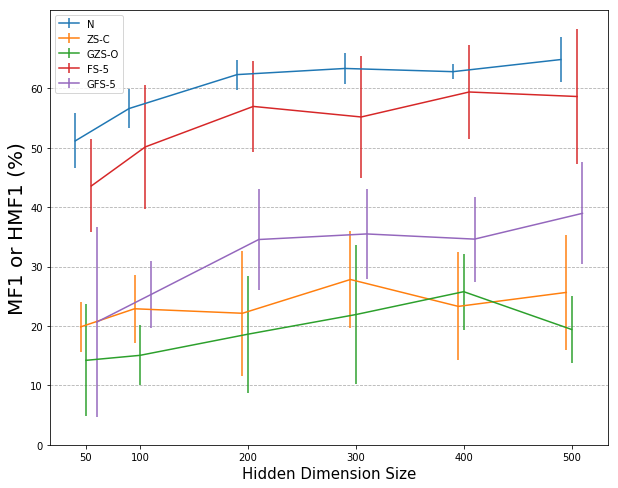

In [197]:
zs_random   = ['ZS-O', 'ZS-C']
random.shuffle(zs_random)
gzs_random  = ['GZS-O', 'GZS-C']
random.shuffle(gzs_random)
fs_random   = ['FS-1', 'FS-2', 'FS-5', 'FS-10']
random.shuffle(fs_random)
gfs_random  = ['GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']
random.shuffle(gfs_random)

settings_random = ['N'] + zs_random[:1] + gzs_random[:1] + fs_random[:1] + gfs_random[:1]

_min_y = min(scores[setting]['y'][l_num] - scores[setting]['y_std'][l_num] for setting in settings_random for l_num, _ in enumerate(scores[setting]['x']))
_max_y = max(scores[setting]['y'][l_num] - scores[setting]['y_std'][l_num] for setting in settings_random for l_num, _ in enumerate(scores[setting]['x']))

fig = plt.figure(figsize=(10,8))

for s_num, setting in enumerate(settings_random):
    plt.errorbar([x + (s_num-2)*5 for x in scores[setting]['x']], scores[setting]['y'], yerr=scores[setting]['y_std'], label=setting)

plt.ylabel('MF1 or HMF1 (%)', fontsize=20)
plt.xlabel('Hidden Dimension Size', fontsize=15)
plt.yticks(range(round_down(_min_y, 10), round_up(_max_y, 10), 10))
plt.xticks(scores['N']['x'])
plt.grid(linestyle='--', axis='y')

plt.legend(loc='upper left')
fig = plt.gcf()
plt.show()
fig.savefig('../../Thesis Document/Code/Images/Baseline_Hidden_Dimension.pdf', bbox_inches='tight')

### 1 vs 2 BiLSTMs

In [20]:
scores = {setting: {config: {} for config in [50, 100, 200, 300, 400, 500]} for setting in settings}

df_double = df_test.loc[6:11, (slice(None))]
df_double = df_double.rename(index={key: key-6 for key in df_double.index.values.tolist()})

for setting in scores:
    for config_num, layer_size in enumerate(scores[setting]):
        # Compute the difference
        df_diff = df_test.loc[0:5, (slice(None))].T.loc[setting, (slice(None))][config_num].subtract(df_double.T.loc[setting, (slice(None))][config_num])

        # Assert whether difference is statistical significant or not
        scores[setting][layer_size]['mean']    = df_diff.mean()
        scores[setting][layer_size]['std']     = df_diff.std()
        scores[setting][layer_size]['p_value'] = ttest_ind(df_test.loc[0:5, (slice(None))].T.loc[setting, (slice(None))][config_num],
                                                           df_double.T.loc[setting, (slice(None))][config_num])[1]

print(sum(True for setting in scores for config in scores[setting]))
print(sum(True for setting in scores for config in scores[setting] if scores[setting][config]['mean'] > 0))
print(sum(True for setting in scores for config in scores[setting] if (scores[setting][config]['p_value'] < 0.05 and scores[setting][config]['mean'] > 0)))
print(sum(True for setting in scores for config in scores[setting] if scores[setting][config]['mean'] < 0))
print(sum(True for setting in scores for config in scores[setting] if (scores[setting][config]['p_value'] < 0.05 and scores[setting][config]['mean'] < 0)))

78
63
9
15
0


#### Normal

In [89]:
relevant_settings = ['N']

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|}" + "\n"
latex_header += r"Hidden Layer Size & NL   \\ \hline" + "\n"


latex_body = r""

for l_num, layer_size in enumerate([50, 100, 200, 300, 400, 500]):
    if ((l_num + 1) % 2 == 0):
        latex_body += r"\rowcolor[HTML]{EFEFEF} " + "\n"#r"\rowcolor{lightgray} "#
    latex_body += r"{} & ".format(layer_size)
    for setting_num, setting in enumerate(relevant_settings):
        mean_len = max(len(str(int(math.modf(scores[setting][_layer_size]['mean'])[1]))) for _layer_size in [50, 100, 200, 300, 400, 500])
        std_len  = max(len(str(int(math.modf(scores[setting][_layer_size]['std'])[1]))) for _layer_size in [50, 100, 200, 300, 400, 500])

        mean    = scores[setting][layer_size]['mean']
        std     = scores[setting][layer_size]['std']
        p_value = scores[setting][layer_size]['p_value']

        if (p_value > 0.05):
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean= mean_len + 3, width_std = std_len + 3)
        else:
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean= mean_len + 3, width_std = std_len + 3) + r"} "
        if (setting_num + 1 < len(relevant_settings)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{Difference of using 1 vs 2 BiLSTM(s) (Baseline - NL setting)}" + "\n"
latex_footer += r"\label{tab:Difference-of-Using-1-vs-2-BiLSTMs-Baseline-NL-Setting}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for the \ac{NL} setting, the differences of using a single \ac{BiLSTM} vs using two \acp{BiLSTM}, i.e. we compute metric\_diff(1 \ac{BiLSTM}, 2 \acp{BiLSTM}) for each \ac{HT} fold and then average over folds. All other hyperparameters are fixed. Bold face results indicate statistical significance at a p-value of 0.05, under a t-test (in this case no differences were statistical significant)." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|}
Hidden Layer Size & NL   \\ \hline
50 & -1.33 $\pm$ 4.24 \\
\rowcolor[HTML]{EFEFEF} 
100 & -3.50 $\pm$ 3.94 \\
200 & -0.21 $\pm$ 2.17 \\
\rowcolor[HTML]{EFEFEF} 
300 & -0.46 $\pm$ 3.39 \\
400 & -0.90 $\pm$ 4.15 \\
\rowcolor[HTML]{EFEFEF} 
500 & -0.78 $\pm$ 2.59 \\
\end{tabular}
\caption{Difference of using 1 vs 2 BiLSTM(s) (Baseline - NL setting)}
\label{tab:Difference-of-Using-1-vs-2-BiLSTMs-Baseline-NL-Setting}
\medskip
\small
This table shows, for the \ac{NL} setting, the differences of using a single \ac{BiLSTM} vs using two \acp{BiLSTM}, i.e. we compute metric\_diff(1 \ac{BiLSTM}, 2 \acp{BiLSTM}) for each \ac{HT} fold and then average over folds. All other hyperparameters are fixed. Bold face results indicate statistical significance at a p-value of 0.05, under a t-test (in this case no differences were statistical significant).
\end{table}



#### (G)ZS

In [90]:
relevant_settings = ['ZS-O', 'ZS-C', 'GZS-O', 'GZS-C']

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|c|c|}" + "\n"
latex_header += r"                                                      & \multicolumn{2}{c|}{ZS} & \multicolumn{2}{c|}{GZS} \\ \cline{2-5}" + "\n"
latex_header += r"\multirow{-2}{*}[0.4cm]{\thead{Hidden \\ Layer Size}} & O-Set      & C-Set      & O-Set        & C-Set     \\ \hline" + "\n"


latex_body = r""

for l_num, layer_size in enumerate([50, 100, 200, 300, 400, 500]):
    if ((l_num + 1) % 2 == 0):
        latex_body += r"\rowcolor[HTML]{EFEFEF} " + "\n"#r"\rowcolor{lightgray} "#
    latex_body += r"{} & ".format(layer_size)
    for setting_num, setting in enumerate(relevant_settings):
        mean_len = max(len(str(int(math.modf(scores[setting][_layer_size]['mean'])[1]))) for _layer_size in [50, 100, 200, 300, 400, 500])
        std_len  = max(len(str(int(math.modf(scores[setting][_layer_size]['std'])[1]))) for _layer_size in [50, 100, 200, 300, 400, 500])

        mean    = scores[setting][layer_size]['mean']
        std     = scores[setting][layer_size]['std']
        p_value = scores[setting][layer_size]['p_value']

        if (p_value > 0.05):
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean= mean_len + 3, width_std = std_len + 3)
        else:
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean= mean_len + 3, width_std = std_len + 3) + r"} "
        if (setting_num + 1 < len(relevant_settings)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{Difference of using 1 vs 2 BiLSTM(s) (Baseline - (G)ZSL settings)}" + "\n"
latex_footer += r"\label{tab:Difference-of-Using-1-vs-2-BiLSTMs-Baseline-(G)ZSL-Settings}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for our baseline and the \ac{(G)ZSL} settings, the differences of using a single \ac{BiLSTM} vs using two \acp{BiLSTM}, i.e. we compute metric\_diff(1 \ac{BiLSTM}, 2 \acp{BiLSTM}) for each \ac{HT} fold and then average over folds. All other hyperparameters are fixed. Bold face results indicate statistical significance at a p-value of 0.05, under a t-test." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|c|c|}
                                                      & \multicolumn{2}{c|}{ZS} & \multicolumn{2}{c|}{GZS} \\ \cline{2-5}
\multirow{-2}{*}[0.4cm]{\thead{Hidden \\ Layer Size}} & O-Set      & C-Set      & O-Set        & C-Set     \\ \hline
50 & ~6.55 $\pm$ 6.69~ & \textbf{~8.47 $\pm$ 3.04~} & ~5.10 $\pm$ 6.13~ & ~1.45 $\pm$ 1.99 \\
\rowcolor[HTML]{EFEFEF} 
100 & ~6.30 $\pm$ 6.54~ & \textbf{10.47 $\pm$ 4.38~} & ~3.54 $\pm$ 5.79~ & ~3.05 $\pm$ 4.20 \\
200 & ~5.62 $\pm$ 7.05~ & ~5.00 $\pm$ 8.04~ & ~6.24 $\pm$ 14.36 & ~1.18 $\pm$ 1.73 \\
\rowcolor[HTML]{EFEFEF} 
300 & ~7.87 $\pm$ 10.19 & \textbf{13.22 $\pm$ 7.88~} & \textbf{15.55 $\pm$ 9.97~} & ~0.61 $\pm$ 0.94 \\
400 & 10.36 $\pm$ 5.82~ & ~3.09 $\pm$ 10.10 & \textbf{14.86 $\pm$ 4.81~} & ~1.54 $\pm$ 4.32 \\
\rowcolor[HTML]{EFEFEF} 
500 & ~8.70 $\pm$ 13.24 & ~8.27 $\pm$ 10.44 & ~5.08 $\pm$ 2.89~ & -1.69 $\pm$ 3.71 \\
\end{tabular}
\caption{Difference of using 1 vs 2 BiLSTM(s) (Baseline 

#### FS

In [92]:
relevant_settings = ['FS-1', 'FS-2', 'FS-5', 'FS-10']

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|c|c|}" + "\n"
latex_header += r"                                                      & \multicolumn{4}{c|}{FS} \\ \cline{2-5}" + "\n"
latex_header += r"\multirow{-2}{*}[0.4cm]{\thead{Hidden \\ Layer Size}} & 1          & 2          & 5            & 10        \\ \hline" + "\n"


latex_body = r""

for l_num, layer_size in enumerate([50, 100, 200, 300, 400, 500]):
    if ((l_num + 1) % 2 == 0):
        latex_body += r"\rowcolor[HTML]{EFEFEF} " + "\n"#r"\rowcolor{lightgray} "#
    latex_body += r"{} & ".format(layer_size)
    for setting_num, setting in enumerate(relevant_settings):
        mean_len = max(len(str(int(math.modf(scores[setting][_layer_size]['mean'])[1]))) for _layer_size in [50, 100, 200, 300, 400, 500])
        std_len  = max(len(str(int(math.modf(scores[setting][_layer_size]['std'])[1]))) for _layer_size in [50, 100, 200, 300, 400, 500])

        mean    = scores[setting][layer_size]['mean']
        std     = scores[setting][layer_size]['std']
        p_value = scores[setting][layer_size]['p_value']

        if (p_value > 0.05):
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean= mean_len + 3, width_std = std_len + 3)
        else:
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean= mean_len + 3, width_std = std_len + 3) + r"} "
        if (setting_num + 1 < len(relevant_settings)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{Difference of using 1 vs 2 BiLSTM(s) (Baseline - FSL settings)}" + "\n"
latex_footer += r"\label{tab:Difference-of-Using-1-vs-2-BiLSTMs-Baseline-FSL-Settings}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for our baseline and the \ac{FSL} settings, the differences of using a single \ac{BiLSTM} vs using two \acp{BiLSTM}, i.e. we compute metric\_diff(1 \ac{BiLSTM}, 2 \acp{BiLSTM}) for each \ac{HT} fold and then average over folds. All other hyperparameters are fixed. Bold face results indicate statistical significance at a p-value of 0.05, under a t-test (in this case no differences were statistical significant)." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|c|c|}
                                                      & \multicolumn{4}{c|}{FS} \\ \cline{2-5}
\multirow{-2}{*}[0.4cm]{\thead{Hidden \\ Layer Size}} & 1          & 2          & 5            & 10        \\ \hline
50 & ~6.03 $\pm$ 5.49 & 7.31 $\pm$ 5.56~ & -2.19 $\pm$ 5.35 & ~1.20 $\pm$ 4.64 \\
\rowcolor[HTML]{EFEFEF} 
100 & ~4.41 $\pm$ 6.62 & 4.16 $\pm$ 11.19 & -0.24 $\pm$ 7.67 & ~4.16 $\pm$ 6.45 \\
200 & ~4.02 $\pm$ 8.44 & 1.61 $\pm$ 3.89~ & ~0.50 $\pm$ 5.20 & ~0.81 $\pm$ 4.04 \\
\rowcolor[HTML]{EFEFEF} 
300 & ~5.17 $\pm$ 5.11 & 5.22 $\pm$ 4.73~ & ~1.69 $\pm$ 9.88 & -7.04 $\pm$ 6.13 \\
400 & ~4.40 $\pm$ 9.21 & 0.51 $\pm$ 4.74~ & ~7.23 $\pm$ 9.31 & -2.32 $\pm$ 5.53 \\
\rowcolor[HTML]{EFEFEF} 
500 & 10.02 $\pm$ 7.58 & 2.88 $\pm$ 6.13~ & -0.27 $\pm$ 6.01 & ~4.11 $\pm$ 4.50 \\
\end{tabular}
\caption{Difference of using 1 vs 2 BiLSTM(s) (Baseline - FSL settings)}
\label{tab:Difference-of-Using-1-vs-2-BiLSTMs-Baseline-FSL-Settings}
\med

#### GFS

In [93]:
relevant_settings = ['GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|c|c|}" + "\n"
latex_header += r"                                                      & \multicolumn{4}{c|}{GFS} \\ \cline{2-5}" + "\n"
latex_header += r"\multirow{-2}{*}[0.4cm]{\thead{Hidden \\ Layer Size}} & 1          & 2          & 5            & 10        \\ \hline" + "\n"


latex_body = r""

for l_num, layer_size in enumerate([50, 100, 200, 300, 400, 500]):
    if ((l_num + 1) % 2 == 0):
        latex_body += r"\rowcolor[HTML]{EFEFEF} " + "\n"#r"\rowcolor{lightgray} "#
    latex_body += r"{} & ".format(layer_size)
    for setting_num, setting in enumerate(relevant_settings):
        mean_len = max(len(str(int(math.modf(scores[setting][_layer_size]['mean'])[1]))) for _layer_size in [50, 100, 200, 300, 400, 500])
        std_len  = max(len(str(int(math.modf(scores[setting][_layer_size]['std'])[1]))) for _layer_size in [50, 100, 200, 300, 400, 500])

        mean    = scores[setting][layer_size]['mean']
        std     = scores[setting][layer_size]['std']
        p_value = scores[setting][layer_size]['p_value']

        if (p_value > 0.05):
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean= mean_len + 3, width_std = std_len + 3)
        else:
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean= mean_len + 3, width_std = std_len + 3) + r"} "
        if (setting_num + 1 < len(relevant_settings)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{Difference of using 1 vs 2 BiLSTM(s) (Baseline - GFSL settings)}" + "\n"
latex_footer += r"\label{tab:Difference-of-Using-1-vs-2-BiLSTMs-Baseline-GFSL-Settings}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for our baseline and the \ac{GFSL} settings, the differences of using a single \ac{BiLSTM} vs using two \acp{BiLSTM}, i.e. we compute metric\_diff(1 \ac{BiLSTM}, 2 \acp{BiLSTM}) for each \ac{HT} fold and then average over folds. All other hyperparameters are fixed. Bold face results indicate statistical significance at a p-value of 0.05, under a t-test." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|c|c|}
                                                      & \multicolumn{4}{c|}{GFS} \\ \cline{2-5}
\multirow{-2}{*}[0.4cm]{\thead{Hidden \\ Layer Size}} & 1          & 2          & 5            & 10        \\ \hline
50 & ~3.58 $\pm$ 5.26~ & \textbf{~8.78 $\pm$ 7.08} & -0.24 $\pm$ 6.18 & 3.35 $\pm$ 7.44 \\
\rowcolor[HTML]{EFEFEF} 
100 & ~5.77 $\pm$ 5.60~ & 10.76 $\pm$ 6.26 & -3.07 $\pm$ 5.80 & 3.44 $\pm$ 5.16 \\
200 & \textbf{~9.69 $\pm$ 8.04~} & ~6.97 $\pm$ 9.06 & ~2.89 $\pm$ 7.91 & -0.70 $\pm$ 6.26 \\
\rowcolor[HTML]{EFEFEF} 
300 & ~9.08 $\pm$ 11.26 & 12.01 $\pm$ 5.12 & ~4.00 $\pm$ 9.82 & 0.50 $\pm$ 6.54 \\
400 & \textbf{~9.71 $\pm$ 5.96~} & ~7.43 $\pm$ 9.36 & ~0.72 $\pm$ 5.99 & 5.86 $\pm$ 5.73 \\
\rowcolor[HTML]{EFEFEF} 
500 & \textbf{10.25 $\pm$ 10.37} & ~4.28 $\pm$ 6.13 & ~4.85 $\pm$ 5.15 & 1.75 $\pm$ 3.43 \\
\end{tabular}
\caption{Difference of using 1 vs 2 BiLSTM(s) (Baseline - GFSL settings)}
\label{tab:Difference-of-Using-1-v

## ESIM-StS

In [21]:
saved_states = '..' + os.sep + 'saved_models_states'
dataset_type = 'hyperparameter_tuning'
config_ids = list(range(24))
model_type = 'ESIM_StS'
experiment_type = 'sub_obj_masking'
settings = ['N', 'ZS-O', 'ZS-C', 'FS-1', 'FS-2', 'FS-5', 'FS-10', 'GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']
folds = list(range(5))

selection_metric = {'N': 'MacroF1', 'ZS': 'MacroF1', 'GZS': 'HarmonicMacroF1', 'FS': 'MacroF1', 'GFS': 'HarmonicMacroF1'}

In [22]:
dolphins_dataframe_dict_test = {}

for setting in settings:
    dolphins_dataframe_dict_test[setting] = {}
    for fold in folds:
        dolphins_dataframe_dict_test[setting][fold] = {}
        for config_id in config_ids:
            mma_path = join_path([saved_states, dataset_type, model_type, 'config_' + str(config_id), experiment_type, setting,
                                  str(fold), 'saved_states', 'MMa' + os.sep])
            last_epoch = max([int(file.split('.')[-2]) for file in os.listdir(mma_path) if file.endswith('.ckp')])

            mma = MetricsManager(None, None, None, None, None, None, None, None, None, just_MMa=True, 
                                 load_path=join_path(get_path_components(mma_path)[:-1]) + os.sep, load_epoch_or_best=last_epoch)
            dolphins_dataframe_dict_test[setting][fold][config_id] = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).epoch_history[-1]

In [23]:
df_test = dolphins.DataFrame.from_dict({(i,j): dolphins_dataframe_dict_test[i][j] 
                                   for i in dolphins_dataframe_dict_test.keys() 
                                   for j in dolphins_dataframe_dict_test[i].keys()},
                                  orient='columns')
df_test.index.set_names(['Configuration'], inplace=True)
df_test.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_mean = df_test.mean(axis=1, level=0)
def_test_std  = df_test.std(axis=1, level=0)
dolphins.concat([def_test_mean, def_test_std])

Setting,N,ZS-O,ZS-C,FS-1,FS-2,FS-5,FS-10,GZS-O,GZS-C,GFS-1,GFS-2,GFS-5,GFS-10
Configuration,,,,,,,,,,,,,
0,64.682383,32.310883,23.316155,36.865414,41.395153,56.797304,66.288457,22.970178,3.461490,11.678130,17.001908,40.626412,52.851117
1,68.844825,34.907954,27.951682,41.788514,49.278349,63.839538,69.117170,23.825416,3.090672,18.995476,26.636112,40.833020,53.090867
2,68.722307,37.829801,35.087774,42.944667,50.546535,66.490311,71.754742,26.628938,4.171841,24.717190,34.826066,45.993727,59.108646
3,64.302968,26.497780,23.111204,38.305779,46.635959,53.360338,67.107008,23.979517,1.223057,9.261803,22.650416,38.859316,48.570368
4,67.477492,37.825731,29.136032,39.997502,53.438954,58.640635,70.988666,22.065887,4.124538,13.197386,30.106177,41.128516,53.834599
5,69.781357,36.988243,28.692086,45.168435,51.969207,67.243369,73.046943,23.680287,5.906769,20.989027,31.758662,45.087277,60.008621
6,62.121712,21.719976,13.221929,28.394826,47.383163,53.658830,64.076185,11.121780,0.000000,2.717912,6.565502,32.018804,41.748660
7,66.088785,22.989782,11.650912,28.862582,45.135991,63.888809,68.145551,10.151743,1.037568,6.128824,11.690763,39.106937,50.649870
8,69.611961,26.380629,19.583250,35.040040,44.237987,61.164657,70.315901,8.734049,0.058270,8.491684,19.840292,41.474256,50.220261


In [112]:
print(df_test.mean(axis=1).idxmax(), df_test.mean(axis=1).max())
display(df_test.mean(axis=1))

17 44.48807975193452


Configuration
0     36.172691
1     40.169199
2     43.755580
3     35.681963
4     40.150932
5     43.101560
6     29.596098
7     32.732932
8     35.011787
9     29.713350
10    33.846541
11    34.900314
12    39.097508
13    42.384135
14    43.266328
15    37.486383
16    42.106312
17    44.488080
18    28.602032
19    31.462220
20    35.152187
21    28.341405
22    31.861545
23    35.309360
dtype: float64

### Intermediate Layers' Dimension

In [113]:
scores = {setting: {'x'    : [50, 100, 200],
                    'y'    : [def_test_mean[setting][key] for key in def_test_mean[setting].keys()[15:18]],
                    'y_std': [def_test_std[setting][key] for key in def_test_std[setting].keys()[15:18]],
                   } for setting in def_test_mean.keys()
         }

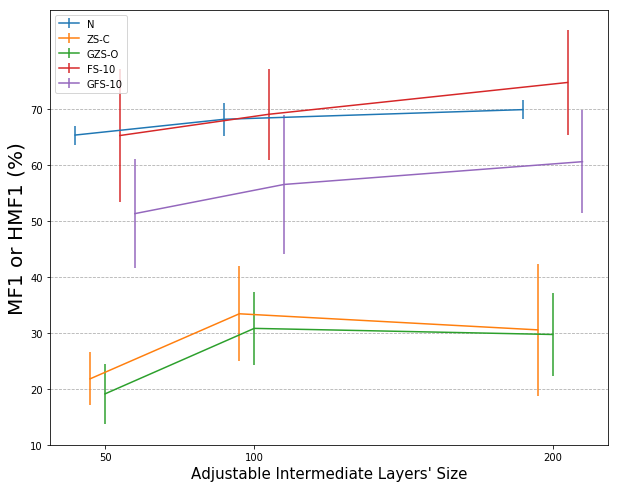

In [172]:
zs_random   = ['ZS-O', 'ZS-C']
random.shuffle(zs_random)
gzs_random  = ['GZS-O', 'GZS-C']
random.shuffle(gzs_random)
fs_random   = ['FS-1', 'FS-2', 'FS-5', 'FS-10']
random.shuffle(fs_random)
gfs_random  = ['GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']
random.shuffle(gfs_random)

settings_random = ['N'] + zs_random[:1] + gzs_random[:1] + fs_random[:1] + gfs_random[:1]

_min_y = min(scores[setting]['y'][l_num] - scores[setting]['y_std'][l_num] for setting in settings_random for l_num, _ in enumerate(scores[setting]['x']))
_max_y = max(scores[setting]['y'][l_num] - scores[setting]['y_std'][l_num] for setting in settings_random for l_num, _ in enumerate(scores[setting]['x']))

fig = plt.figure(figsize=(10,8))

for s_num, setting in enumerate(settings_random):
    plt.errorbar([x + (s_num-2)*5 for x in scores[setting]['x']], scores[setting]['y'], yerr=scores[setting]['y_std'], label=setting)

plt.ylabel('MF1 or HMF1 (%)', fontsize=20)
plt.xlabel('Adjustable Intermediate Layers\' Size', fontsize=15)
plt.yticks(range(round_down(_min_y, 10), round_up(_max_y, 10), 10))
plt.xticks(scores['N']['x'])
plt.grid(linestyle='--', axis='y')

plt.legend(loc='upper left')
fig = plt.gcf()
plt.show()
fig.savefig('../../Thesis Document/Code/Images/ESIM_Intermediate_Layers_Size.pdf', bbox_inches='tight')

### 1 vs 2 BiLSTMs

In [99]:
pre_train_el = [True, False]
seb  = [True, False]
lrns = [0.025, 0.075]
fbhs  = [50, 100, 200]

config_num_to_hyperparameters = []

for pretrained_embedding_layer in pre_train_el:
    for _seb in seb:
        for _lrns in lrns:
            for fbhs_l_size in fbhs:
                config_num_to_hyperparameters.append({'pretrain': pretrained_embedding_layer,
                                                      'seb'     : _seb,
                                                      'lrns'    : _lrns,
                                                      'l_size'  : fbhs_l_size})

print([(c_num, val) for c_num, val in enumerate(config_num_to_hyperparameters)])

[(0, {'pretrain': True, 'seb': True, 'lrns': 0.025, 'l_size': 50}), (1, {'pretrain': True, 'seb': True, 'lrns': 0.025, 'l_size': 100}), (2, {'pretrain': True, 'seb': True, 'lrns': 0.025, 'l_size': 200}), (3, {'pretrain': True, 'seb': True, 'lrns': 0.075, 'l_size': 50}), (4, {'pretrain': True, 'seb': True, 'lrns': 0.075, 'l_size': 100}), (5, {'pretrain': True, 'seb': True, 'lrns': 0.075, 'l_size': 200}), (6, {'pretrain': True, 'seb': False, 'lrns': 0.025, 'l_size': 50}), (7, {'pretrain': True, 'seb': False, 'lrns': 0.025, 'l_size': 100}), (8, {'pretrain': True, 'seb': False, 'lrns': 0.025, 'l_size': 200}), (9, {'pretrain': True, 'seb': False, 'lrns': 0.075, 'l_size': 50}), (10, {'pretrain': True, 'seb': False, 'lrns': 0.075, 'l_size': 100}), (11, {'pretrain': True, 'seb': False, 'lrns': 0.075, 'l_size': 200}), (12, {'pretrain': False, 'seb': True, 'lrns': 0.025, 'l_size': 50}), (13, {'pretrain': False, 'seb': True, 'lrns': 0.025, 'l_size': 100}), (14, {'pretrain': False, 'seb': True, 'l

In [24]:
scores = {setting: {config: {} for config in range(12)} for setting in settings}

df_single = dolphins.concat([df_test.loc[0:5, (slice(None))],
                             df_test.loc[12:17, (slice(None))].rename(index={key: key-6 for key in df_test.loc[12:17, (slice(None))].index.values.tolist()})])
df_double = dolphins.concat([df_test.loc[6:11, (slice(None))].rename(index={key: key-6 for key in df_test.loc[6:11, (slice(None))].index.values.tolist()}),
                             df_test.loc[18:23, (slice(None))].rename(index={key: key-12 for key in df_test.loc[18:23, (slice(None))].index.values.tolist()})])
# display(df_single.subtract(df_double))

for setting in scores:
    for config_num, layer_size in enumerate(scores[setting]):
        # Compute the difference
        df_diff = df_single.T.loc[setting, (slice(None))][config_num].subtract(df_double.T.loc[setting, (slice(None))][config_num])

        # Assert whether difference is statistical significant or not
        scores[setting][layer_size]['mean']    = df_diff.mean()
        scores[setting][layer_size]['std']     = df_diff.std()
        scores[setting][layer_size]['p_value'] = ttest_ind(df_single.T.loc[setting, (slice(None))][config_num],
                                                           df_double.T.loc[setting, (slice(None))][config_num])[1]

print(sum(True for setting in scores for config in scores[setting]))
print(sum(True for setting in scores for config in scores[setting] if scores[setting][config]['mean'] > 0))
print(sum(True for setting in scores for config in scores[setting] if (scores[setting][config]['p_value'] < 0.05 and scores[setting][config]['mean'] > 0)))
print(sum(True for setting in scores for config in scores[setting] if scores[setting][config]['mean'] < 0))
print(sum(True for setting in scores for config in scores[setting] if (scores[setting][config]['p_value'] < 0.05 and scores[setting][config]['mean'] < 0)))

156
149
60
7
1


### Pretrained Input Encoding Component

In [27]:
scores = {setting: {config: {} for config in range(12)} for setting in settings}

df_pre    = df_test.loc[0:11, (slice(None))]
df_no_pre = df_test.loc[12:23, (slice(None))].rename(index={key: key-12 for key in df_test.loc[12:23, (slice(None))].index.values.tolist()})
# display(df_no_pre.subtract(df_pre))

for setting in scores:
    for config_num, layer_size in enumerate(scores[setting]):
        # Compute the difference
        df_diff = df_no_pre.T.loc[setting, (slice(None))][config_num].subtract(df_pre.T.loc[setting, (slice(None))][config_num])

        # Assert whether difference is statistical significant or not
        scores[setting][layer_size]['mean']    = df_diff.mean()
        scores[setting][layer_size]['std']     = df_diff.std()
        scores[setting][layer_size]['p_value'] = ttest_ind(df_no_pre.T.loc[setting, (slice(None))][config_num],
                                                           df_pre.T.loc[setting, (slice(None))][config_num])[1]

print(sum(True for setting in scores for config in scores[setting]))
print(sum(True for setting in scores for config in scores[setting] if scores[setting][config]['mean'] > 0))
print(sum(True for setting in scores for config in scores[setting] if (scores[setting][config]['p_value'] < 0.05 and scores[setting][config]['mean'] > 0)))
print(sum(True for setting in scores for config in scores[setting] if scores[setting][config]['mean'] < 0))
print(sum(True for setting in scores for config in scores[setting] if (scores[setting][config]['p_value'] < 0.05 and scores[setting][config]['mean'] < 0)))

156
88
2
68
3


# -------------------------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------------------------

# Final Evaluation

## Baseline

### Sub_Obj_Masking

In [299]:
saved_states = '..' + os.sep + 'saved_models_states'
dataset_type = 'final_evaluation'
config_ids = list(range(1))
model_type = 'Baseline_BiLSTM'
experiment_type = 'sub_obj_masking'
settings = ['N', 'ZS-O', 'ZS-C', 'FS-1', 'FS-2', 'FS-5', 'FS-10', 'GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']
folds = list(range(10))

selection_metric = {'N': 'MacroF1', 'ZS': 'MacroF1', 'GZS': 'HarmonicMacroF1', 'FS': 'MacroF1', 'GFS': 'HarmonicMacroF1'}

In [300]:
dict_test_B_SO                    = {}
dict_test_B_SO_generalised_seen   = {}
dict_test_B_SO_generalised_unseen = {}
dict_test_B_SO_val                = {}

for setting in settings:
    dict_test_B_SO[setting]     = {}
    dict_test_B_SO_val[setting] = {}
    if (setting[0] == 'G'):
        dict_test_B_SO_generalised_seen[setting]   = {}
        dict_test_B_SO_generalised_unseen[setting] = {}
    for fold in folds:
        dict_test_B_SO[setting][fold]     = {}
        dict_test_B_SO_val[setting][fold] = {}
        if (setting[0] == 'G'):
            dict_test_B_SO_generalised_seen[setting][fold]   = {}
            dict_test_B_SO_generalised_unseen[setting][fold] = {}
        for config_id in config_ids:
            mma_path = join_path([saved_states, dataset_type, model_type, 'config_' + str(config_id), experiment_type, setting,
                                  str(fold), 'saved_states', 'MMa' + os.sep])
            last_epoch = max([int(file.split('.')[-2]) for file in os.listdir(mma_path) if file.endswith('.ckp')])
            best_epoch = -1 if any([True for file in os.listdir(mma_path) if file.endswith('.bst')]) else last_epoch

            # TEST SCORES
            mma = MetricsManager(None, None, None, None, None, None, None, None, None, just_MMa=True, 
                                 load_path=join_path(get_path_components(mma_path)[:-1]) + os.sep, load_epoch_or_best=last_epoch)
            dict_test_B_SO[setting][fold][config_id] = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).epoch_history[-1]
            if (setting[0] == 'G'):
                dict_test_B_SO_generalised_seen[setting][fold][config_id]   = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).seen_unseen_MacroF1['seen'].epoch_history[-1]
                dict_test_B_SO_generalised_unseen[setting][fold][config_id] = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).seen_unseen_MacroF1['unseen'].epoch_history[-1]

            # VALIDATION
            mma = MetricsManager(None, None, None, None, None, None, None, None, None, just_MMa=True, 
                                 load_path=join_path(get_path_components(mma_path)[:-1]) + os.sep, load_epoch_or_best=best_epoch)
            dict_test_B_SO_val[setting][fold][config_id] = mma.get_specific_metric('val', selection_metric[setting.split('-')[0]])

In [301]:
df_test_B_SO = dolphins.DataFrame.from_dict({(i,j): dict_test_B_SO[i][j] 
                                             for i in dict_test_B_SO.keys()
                                             for j in dict_test_B_SO[i].keys()},
                                            orient='columns')
df_test_B_SO.index.set_names(['Configuration'], inplace=True)
df_test_B_SO.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_B_SO_mean = df_test_B_SO.mean(axis=1, level=0)
def_test_B_SO_std  = df_test_B_SO.std(axis=1, level=0)


# Seen Classes
df_test_B_SO_generalised_seen = dolphins.DataFrame.from_dict({(i,j): dict_test_B_SO_generalised_seen[i][j]
                                                              for i in dict_test_B_SO_generalised_seen.keys()
                                                              for j in dict_test_B_SO_generalised_seen[i].keys()},
                                                             orient='columns')
df_test_B_SO_generalised_seen.index.set_names(['Configuration'], inplace=True)
df_test_B_SO_generalised_seen.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_B_SO_generalised_seen_mean = df_test_B_SO_generalised_seen.mean(axis=1, level=0)
def_test_B_SO_generalised_seen_std  = df_test_B_SO_generalised_seen.std(axis=1, level=0)


# Unseen Classes
df_test_B_SO_generalised_unseen = dolphins.DataFrame.from_dict({(i,j): dict_test_B_SO_generalised_unseen[i][j]
                                                                for i in dict_test_B_SO_generalised_unseen.keys()
                                                                for j in dict_test_B_SO_generalised_unseen[i].keys()},
                                                               orient='columns')
df_test_B_SO_generalised_unseen.index.set_names(['Configuration'], inplace=True)
df_test_B_SO_generalised_unseen.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_B_SO_generalised_unseen_mean = df_test_B_SO_generalised_unseen.mean(axis=1, level=0)
def_test_B_SO_generalised_unseen_std  = df_test_B_SO_generalised_unseen.std(axis=1, level=0)

display(dolphins.concat([def_test_B_SO_mean, def_test_B_SO_std]))


print("\n\n\n\GENERALISED CASES")
with dolphins.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dolphins.concat([df_test_B_SO[['GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']], df_test_B_SO_generalised_seen, df_test_B_SO_generalised_unseen]))

Setting,N,ZS-O,ZS-C,FS-1,FS-2,FS-5,FS-10,GZS-O,GZS-C,GFS-1,GFS-2,GFS-5,GFS-10
Configuration,,,,,,,,,,,,,
0,54.920394,32.904565,23.897590,41.742934,46.391942,59.061500,67.305942,18.229093,2.060506,13.583538,23.288247,34.797745,48.125251
0,1.145097,3.873592,5.457216,4.476721,4.100009,7.415075,5.361781,5.395548,2.108063,4.116740,3.686448,6.524887,4.647241





\GENERALISED CASES


Setting            GZS-O                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              19.924799  15.416274  29.482244  11.069856  22.257099   
0              53.689770  58.577911  57.610923  56.211521  58.252688   
0              12.232131   8.876127  19.809974   6.139456  13.756600   

Setting                                                                 GZS-C  \
Fold                   5          6          7          8          9        0   
Configuration                                                                   
0              21.340058  11.945772  15.590608  17.261607  18.002610   0.0000   
0              58.041437  59.619015  59.095375  59.420420  56.670969  55.6787   
0              13.073368   6.637899   8.979840  10.097457  10.700992   0.0000   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0               1.100440   4.298796   0.991001   6.538241   2.998624   
0              57.292620  53.781602  55.061505  54.880377  51.174760   
0               0.555556   2.238875   0.500000   3.476190   1.544565   

Setting                                                        GFS-1  \
Fold                   6          7          8          9          0   
Configuration                                                          
0               0.452720   0.000000   2.786379   1.438858  13.759288   
0              56.360916  54.419012  56.250698  50.802117  56.101190   
0               0.227273   0.000000   1.428571   0.729763   7.841204   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0              15.975620  16.098792  19.778388  10.809214   5.138570   
0              53.255974  56.175395  54.225060  51.463075  56.267654   
0               9.397302   9.395711  12.094997   6.038796   2.692216   

Setting                                                        GFS-2  \
Fold                   6          7          8          9          0   
Configuration                                                          
0              13.036598  14.822893  16.443803   9.972212  19.583762   
0              58.185751  57.103514  54.274837  56.184018  58.260565   
0               7.340639   8.516845   9.689770   5.471697  11.770085   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0              22.353183  22.427091  22.052139  21.986025  22.401366   
0              53.525010  51.463976  56.630111  56.028761  55.980920   
0              14.126317  14.337577  13.691935  13.676354  14.002261   

Setting                                                        GFS-5  \
Fold                   6          7          8          9          0   
Configuration                                                          
0              25.875851  22.596502  20.841960  32.764594  36.544332   
0              57.143440  54.637920  55.749469  61.208534  63.645568   
0              16.724555  14.243601  12.816754  22.369408  25.630487   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0              29.350673  37.249846  39.817288  26.798888  45.529177   
0              53.079528  56.689341  55.618183  55.743429  60.383453   
0              20.283201  27.738099  31.008034  17.639600  36.540297   

Setting                                          

### Unmasked

In [27]:
saved_states = '..' + os.sep + 'saved_models_states'
dataset_type = 'final_evaluation'
config_ids = list(range(1))
model_type = 'Baseline_BiLSTM'
experiment_type = 'unmasked'
settings = ['N', 'ZS-O', 'ZS-C', 'FS-1', 'FS-2', 'FS-5', 'FS-10', 'GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']
folds = list(range(10))

selection_metric = {'N': 'MacroF1', 'ZS': 'MacroF1', 'GZS': 'HarmonicMacroF1', 'FS': 'MacroF1', 'GFS': 'HarmonicMacroF1'}

In [28]:
dict_test_B_U                    = {}
dict_test_B_U_generalised_seen   = {}
dict_test_B_U_generalised_unseen = {}
dict_test_B_U_val                = {}

for setting in settings:
    dict_test_B_U[setting]     = {}
    dict_test_B_U_val[setting] = {}
    if (setting[0] == 'G'):
        dict_test_B_U_generalised_seen[setting]   = {}
        dict_test_B_U_generalised_unseen[setting] = {}
    for fold in folds:
        dict_test_B_U[setting][fold]     = {}
        dict_test_B_U_val[setting][fold] = {}
        if (setting[0] == 'G'):
            dict_test_B_U_generalised_seen[setting][fold]   = {}
            dict_test_B_U_generalised_unseen[setting][fold] = {}
        for config_id in config_ids:
            mma_path = join_path([saved_states, dataset_type, model_type, 'config_' + str(config_id), experiment_type, setting,
                                  str(fold), 'saved_states', 'MMa' + os.sep])
            last_epoch = max([int(file.split('.')[-2]) for file in os.listdir(mma_path) if file.endswith('.ckp')])
            best_epoch = -1 if any([True for file in os.listdir(mma_path) if file.endswith('.bst')]) else last_epoch

            # TEST SCORES
            mma = MetricsManager(None, None, None, None, None, None, None, None, None, just_MMa=True, 
                                 load_path=join_path(get_path_components(mma_path)[:-1]) + os.sep, load_epoch_or_best=last_epoch)
            dict_test_B_U[setting][fold][config_id] = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).epoch_history[-1]
            if (setting[0] == 'G'):
                dict_test_B_U_generalised_seen[setting][fold][config_id]   = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).seen_unseen_MacroF1['seen'].epoch_history[-1]
                dict_test_B_U_generalised_unseen[setting][fold][config_id] = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).seen_unseen_MacroF1['unseen'].epoch_history[-1]

            # VALIDATION
            mma = MetricsManager(None, None, None, None, None, None, None, None, None, just_MMa=True, 
                                 load_path=join_path(get_path_components(mma_path)[:-1]) + os.sep, load_epoch_or_best=best_epoch)
            dict_test_B_U_val[setting][fold][config_id] = mma.get_specific_metric('val', selection_metric[setting.split('-')[0]])

In [29]:
df_test_B_U = dolphins.DataFrame.from_dict({(i,j): dict_test_B_U[i][j]
                                            for i in dict_test_B_U.keys()
                                            for j in dict_test_B_U[i].keys()},
                                           orient='columns')
df_test_B_U.index.set_names(['Configuration'], inplace=True)
df_test_B_U.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_B_U_mean = df_test_B_U.mean(axis=1, level=0)
def_test_B_U_std  = df_test_B_U.std(axis=1, level=0)


# Seen Classes
df_test_B_U_generalised_seen = dolphins.DataFrame.from_dict({(i,j): dict_test_B_U_generalised_seen[i][j]
                                                             for i in dict_test_B_U_generalised_seen.keys()
                                                             for j in dict_test_B_U_generalised_seen[i].keys()},
                                                            orient='columns')
df_test_B_U_generalised_seen.index.set_names(['Configuration'], inplace=True)
df_test_B_U_generalised_seen.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_B_U_generalised_seen_mean = df_test_B_U_generalised_seen.mean(axis=1, level=0)
def_test_B_U_generalised_seen_std  = df_test_B_U_generalised_seen.std(axis=1, level=0)


# Unseen Classes
df_test_B_U_generalised_unseen = dolphins.DataFrame.from_dict({(i,j): dict_test_B_U_generalised_unseen[i][j]
                                                                for i in dict_test_B_U_generalised_unseen.keys()
                                                                for j in dict_test_B_U_generalised_unseen[i].keys()},
                                                               orient='columns')
df_test_B_U_generalised_unseen.index.set_names(['Configuration'], inplace=True)
df_test_B_U_generalised_unseen.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_B_U_generalised_unseen_mean = df_test_B_U_generalised_unseen.mean(axis=1, level=0)
def_test_B_U_generalised_unseen_std  = df_test_B_U_generalised_unseen.std(axis=1, level=0)

display(dolphins.concat([def_test_B_U_mean, def_test_B_U_std]))


print("\n\n\n\GENERALISED CASES")
with dolphins.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dolphins.concat([df_test_B_U[['GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']], df_test_B_U_generalised_seen, df_test_B_U_generalised_unseen]))

Setting,N,ZS-O,ZS-C,FS-1,FS-2,FS-5,FS-10,GZS-O,GZS-C,GFS-1,GFS-2,GFS-5,GFS-10
Configuration,,,,,,,,,,,,,
0,40.786597,23.515811,17.348684,27.394079,35.701355,47.505921,59.236273,11.407457,1.150363,7.749966,14.033468,26.963355,34.556288
0,1.490614,4.836777,4.692955,4.525038,6.491818,7.927424,4.273696,2.671071,1.428280,5.640895,6.954457,5.736468,4.261104





\GENERALISED CASES


Setting            GZS-O                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              14.283693   6.755757  14.081991  10.414814  14.723719   
0              47.683829  45.309173  44.262620  46.228749  42.003704   
0               8.399949   3.649992   8.372899   5.868455   8.926354   

Setting                                                                 GZS-C  \
Fold                   5          6          7          8          9        0   
Configuration                                                                   
0               9.893607   9.137204   9.527426  13.404007  11.852356   0.0000   
0              33.311259  45.442338  52.921118  47.797700  43.214903  41.8386   
0               5.809534   5.079251   5.234937   7.794986   6.868006   0.0000   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0               0.000000   2.167618   1.096729   0.619746   1.791438   
0              45.138713  44.107862  42.363711  36.858883  41.093845   
0               0.000000   1.111111   0.555556   0.312500   0.915678   

Setting                                                        GFS-1  \
Fold                   6          7          8          9          0   
Configuration                                                          
0               4.513285   0.000000   0.000000   1.314815  10.529635   
0              43.222371  48.279111  44.115546  47.334885  47.024726   
0               2.380952   0.000000   0.000000   0.666667   5.928571   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0               5.213885  18.491393   8.297203   2.635036   8.644539   
0              42.388850  49.656424  41.932290  45.124576  43.890764   
0               2.777778  11.361048   4.604113   1.357143   4.794413   

Setting                                                        GFS-2  \
Fold                   6          7          8          9          0   
Configuration                                                          
0              10.136812   1.211378  12.339780   0.000000   2.499602   
0              45.729793  46.765912  45.299637  40.398372  43.842090   
0               5.700178   0.613636   7.142744   0.000000   1.286475   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0              17.881847  15.802063  24.943064  13.689618   4.764821   
0              42.339909  43.534547  47.065261  48.861630  44.991059   
0              11.334413   9.652930  16.967697   7.959872   2.515620   

Setting                                                        GFS-5  \
Fold                   6          7          8          9          0   
Configuration                                                          
0              13.540867  10.233770  14.962909  22.016115  25.190407   
0              46.360935  47.060797  44.026926  46.087203  41.896379   
0               7.928256   5.741112   9.013031  14.462455  18.009291   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0              22.178369  36.338401  30.266055  20.195639  30.486281   
0              42.885777  46.906780  47.950480  45.979996  50.984503   
0              14.956581  29.656592  22.111281  12.939508  21.744105   

Setting                                          

### NER_Masking

In [30]:
saved_states = '..' + os.sep + 'saved_models_states'
dataset_type = 'final_evaluation'
config_ids = list(range(1))
model_type = 'Baseline_BiLSTM'
experiment_type = 'NER_masking'
settings = ['N', 'ZS-O', 'ZS-C', 'FS-1', 'FS-2', 'FS-5', 'FS-10', 'GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']
folds = list(range(10))

selection_metric = {'N': 'MacroF1', 'ZS': 'MacroF1', 'GZS': 'HarmonicMacroF1', 'FS': 'MacroF1', 'GFS': 'HarmonicMacroF1'}

In [31]:
dict_test_B_NER                    = {}
dict_test_B_NER_generalised_seen   = {}
dict_test_B_NER_generalised_unseen = {}
dict_test_B_NER_val                = {}

for setting in settings:
    dict_test_B_NER[setting]     = {}
    dict_test_B_NER_val[setting] = {}
    if (setting[0] == 'G'):
        dict_test_B_NER_generalised_seen[setting]   = {}
        dict_test_B_NER_generalised_unseen[setting] = {}
    for fold in folds:
        dict_test_B_NER[setting][fold]     = {}
        dict_test_B_NER_val[setting][fold] = {}
        if (setting[0] == 'G'):
            dict_test_B_NER_generalised_seen[setting][fold]   = {}
            dict_test_B_NER_generalised_unseen[setting][fold] = {}
        for config_id in config_ids:
            mma_path = join_path([saved_states, dataset_type, model_type, 'config_' + str(config_id), experiment_type, setting,
                                  str(fold), 'saved_states', 'MMa' + os.sep])
            last_epoch = max([int(file.split('.')[-2]) for file in os.listdir(mma_path) if file.endswith('.ckp')])
            best_epoch = -1 if any([True for file in os.listdir(mma_path) if file.endswith('.bst')]) else last_epoch

            # TEST SCORES
            mma = MetricsManager(None, None, None, None, None, None, None, None, None, just_MMa=True, 
                                 load_path=join_path(get_path_components(mma_path)[:-1]) + os.sep, load_epoch_or_best=last_epoch)
            dict_test_B_NER[setting][fold][config_id] = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).epoch_history[-1]
            if (setting[0] == 'G'):
                dict_test_B_NER_generalised_seen[setting][fold][config_id]   = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).seen_unseen_MacroF1['seen'].epoch_history[-1]
                dict_test_B_NER_generalised_unseen[setting][fold][config_id] = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).seen_unseen_MacroF1['unseen'].epoch_history[-1]

            # VALIDATION
            mma = MetricsManager(None, None, None, None, None, None, None, None, None, just_MMa=True, 
                                 load_path=join_path(get_path_components(mma_path)[:-1]) + os.sep, load_epoch_or_best=best_epoch)
            dict_test_B_NER_val[setting][fold][config_id] = mma.get_specific_metric('val', selection_metric[setting.split('-')[0]])

In [32]:
df_test_B_NER = dolphins.DataFrame.from_dict({(i,j): dict_test_B_NER[i][j]
                                              for i in dict_test_B_NER.keys()
                                              for j in dict_test_B_NER[i].keys()},
                                             orient='columns')
df_test_B_NER.index.set_names(['Configuration'], inplace=True)
df_test_B_NER.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_B_NER_mean = df_test_B_NER.mean(axis=1, level=0)
def_test_B_NER_std  = df_test_B_NER.std(axis=1, level=0)


# Seen Classes
df_test_B_NER_generalised_seen = dolphins.DataFrame.from_dict({(i,j): dict_test_B_NER_generalised_seen[i][j]
                                                               for i in dict_test_B_NER_generalised_seen.keys()
                                                               for j in dict_test_B_NER_generalised_seen[i].keys()},
                                                              orient='columns')
df_test_B_NER_generalised_seen.index.set_names(['Configuration'], inplace=True)
df_test_B_NER_generalised_seen.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_B_NER_generalised_seen_mean = df_test_B_NER_generalised_seen.mean(axis=1, level=0)
def_test_B_NER_generalised_seen_std  = df_test_B_NER_generalised_seen.std(axis=1, level=0)


# Unseen Classes
df_test_B_NER_generalised_unseen = dolphins.DataFrame.from_dict({(i,j): dict_test_B_NER_generalised_unseen[i][j]
                                                                 for i in dict_test_B_NER_generalised_unseen.keys()
                                                                 for j in dict_test_B_NER_generalised_unseen[i].keys()},
                                                                orient='columns')
df_test_B_NER_generalised_unseen.index.set_names(['Configuration'], inplace=True)
df_test_B_NER_generalised_unseen.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_B_NER_generalised_unseen_mean = df_test_B_NER_generalised_unseen.mean(axis=1, level=0)
def_test_B_NER_generalised_unseen_std  = df_test_B_NER_generalised_unseen.std(axis=1, level=0)

display(dolphins.concat([def_test_B_NER_mean, def_test_B_NER_std]))


print("\n\n\n\GENERALISED CASES")
with dolphins.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dolphins.concat([df_test_B_NER[['GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']], df_test_B_NER_generalised_seen, df_test_B_NER_generalised_unseen]))

Setting,N,ZS-O,ZS-C,FS-1,FS-2,FS-5,FS-10,GZS-O,GZS-C,GFS-1,GFS-2,GFS-5,GFS-10
Configuration,,,,,,,,,,,,,
0,33.616135,22.351174,16.964871,25.442949,31.816962,41.526964,51.833492,9.691217,0.955186,4.971136,9.517288,21.025316,27.522611
0,1.099894,4.571417,4.744643,4.926247,5.306374,7.691055,3.481009,3.962894,1.132370,5.123224,5.849565,6.203245,6.501571





\GENERALISED CASES


Setting            GZS-O                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              10.682281   2.358818   7.287117   9.729618  14.545061   
0              38.396185  39.224407  34.980892  36.261033  42.100287   
0               6.204179   1.215971   4.067191   5.618605   8.791138   

Setting                                                               \
Fold                   5          6          7          8          9   
Configuration                                                          
0              11.300723   7.455679   7.138228  16.242253  10.172388   
0              32.910221  36.757465  40.064371  40.918121  39.179118   
0               6.821556   4.148577   3.918161  10.132064   5.844984   

Setting            GZS-C                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0               0.000000   1.682798   0.000000   0.000000   2.037671   
0              34.751266  39.274870  33.732672  39.190503  32.367049   
0               0.000000   0.859819   0.000000   0.000000   1.051948   

Setting                                                                 GFS-1  \
Fold                   5          6          7          8          9        0   
Configuration                                                                   
0               3.328000   1.158645   1.095478   0.249269   0.000000   0.0000   
0              29.158939  38.235506  38.929778  42.641673  32.908114  35.4002   
0               1.764706   0.588235   0.555556   0.125000   0.000000   0.0000   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0               0.987012  14.144375   3.544564   4.081495   5.962392   
0              37.996715  38.796733  38.006690  38.315716  41.149418   
0               0.500000   8.648754   1.858967   2.155556   3.214048   

Setting                                                       GFS-2  \
Fold                   6          7          8         9          0   
Configuration                                                         
0               9.408882   0.226577  11.356059   0.00000   0.473355   
0              40.272628  37.011038  34.971066  31.52176  39.741616   
0               5.326676   0.113636   6.778633   0.00000   0.238095   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0              16.764520  14.068570  17.240230   5.660818   6.340127   
0              38.199310  39.364315  35.419540  42.412040  35.931110   
0              10.738707   8.564787  11.392801   3.032806   3.476809   

Setting                                                        GFS-5  \
Fold                   6          7          8          9          0   
Configuration                                                          
0              10.946347   2.395677  13.193976   8.089264  20.962368   
0              40.492686  35.763308  35.903064  40.519219  39.908698   
0               6.328571   1.239348   8.082012   4.493137  14.214263   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0              20.181604  26.152221  24.981717   9.863922  24.131141   
0              36.637701  39.110360  41.278449  34.940642  42.440582   
0              13.926439  19.643793  17.910609   5.742534  16.858260   

Setting                                                

# -------------------------------------------------------------------------------------------------------

# -------------------------------------------------------------------------------------------------------

## ESIM_StS

### Sub_Obj_Masking

In [296]:
saved_states = '..' + os.sep + 'saved_models_states'
dataset_type = 'final_evaluation'
config_ids = list(range(1))
model_type = 'ESIM_StS'
experiment_type = 'sub_obj_masking'
settings = ['N', 'ZS-O', 'ZS-C', 'FS-1', 'FS-2', 'FS-5', 'FS-10', 'GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']
folds = list(range(10))

selection_metric = {'N': 'MacroF1', 'ZS': 'MacroF1', 'GZS': 'HarmonicMacroF1', 'FS': 'MacroF1', 'GFS': 'HarmonicMacroF1'}

In [297]:
dict_test_E_SO                    = {}
dict_test_E_SO_generalised_seen   = {}
dict_test_E_SO_generalised_unseen = {}
dict_test_E_SO_val                = {}

for setting in settings:
    dict_test_E_SO[setting]     = {}
    dict_test_E_SO_val[setting] = {}
    if (setting[0] == 'G'):
        dict_test_E_SO_generalised_seen[setting]   = {}
        dict_test_E_SO_generalised_unseen[setting] = {}
    for fold in folds:
        dict_test_E_SO[setting][fold]     = {}
        dict_test_E_SO_val[setting][fold] = {}
        if (setting[0] == 'G'):
            dict_test_E_SO_generalised_seen[setting][fold]   = {}
            dict_test_E_SO_generalised_unseen[setting][fold] = {}
        for config_id in config_ids:
            mma_path = join_path([saved_states, dataset_type, model_type, 'config_' + str(config_id), experiment_type, setting,
                                  str(fold), 'saved_states', 'MMa' + os.sep])
            last_epoch = max([int(file.split('.')[-2]) for file in os.listdir(mma_path) if file.endswith('.ckp')])
            best_epoch = -1 if any([True for file in os.listdir(mma_path) if file.endswith('.bst')]) else last_epoch

            # TEST SCORES
            mma = MetricsManager(None, None, None, None, None, None, None, None, None, just_MMa=True, 
                                 load_path=join_path(get_path_components(mma_path)[:-1]) + os.sep, load_epoch_or_best=last_epoch)
            dict_test_E_SO[setting][fold][config_id] = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).epoch_history[-1]
            if (setting[0] == 'G'):
                dict_test_E_SO_generalised_seen[setting][fold][config_id]   = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).seen_unseen_MacroF1['seen'].epoch_history[-1]
                dict_test_E_SO_generalised_unseen[setting][fold][config_id] = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).seen_unseen_MacroF1['unseen'].epoch_history[-1]

            # VALIDATION
            mma = MetricsManager(None, None, None, None, None, None, None, None, None, just_MMa=True, 
                                 load_path=join_path(get_path_components(mma_path)[:-1]) + os.sep, load_epoch_or_best=best_epoch)
            dict_test_E_SO_val[setting][fold][config_id] = mma.get_specific_metric('val', selection_metric[setting.split('-')[0]])

In [298]:
df_test_E_SO = dolphins.DataFrame.from_dict({(i,j): dict_test_E_SO[i][j] 
                                             for i in dict_test_E_SO.keys()
                                             for j in dict_test_E_SO[i].keys()},
                                            orient='columns')
df_test_E_SO.index.set_names(['Configuration'], inplace=True)
df_test_E_SO.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_E_SO_mean = df_test_E_SO.mean(axis=1, level=0)
def_test_E_SO_std  = df_test_E_SO.std(axis=1, level=0)


# Seen Classes
df_test_E_SO_generalised_seen = dolphins.DataFrame.from_dict({(i,j): dict_test_E_SO_generalised_seen[i][j]
                                                              for i in dict_test_E_SO_generalised_seen.keys()
                                                              for j in dict_test_E_SO_generalised_seen[i].keys()},
                                                             orient='columns')
df_test_E_SO_generalised_seen.index.set_names(['Configuration'], inplace=True)
df_test_E_SO_generalised_seen.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_E_SO_generalised_seen_mean = df_test_E_SO_generalised_seen.mean(axis=1, level=0)
def_test_E_SO_generalised_seen_std  = df_test_E_SO_generalised_seen.std(axis=1, level=0)


# Unseen Classes
df_test_E_SO_generalised_unseen = dolphins.DataFrame.from_dict({(i,j): dict_test_E_SO_generalised_unseen[i][j]
                                                                for i in dict_test_E_SO_generalised_unseen.keys()
                                                                for j in dict_test_E_SO_generalised_unseen[i].keys()},
                                                               orient='columns')
df_test_E_SO_generalised_unseen.index.set_names(['Configuration'], inplace=True)
df_test_E_SO_generalised_unseen.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_E_SO_generalised_unseen_mean = df_test_E_SO_generalised_unseen.mean(axis=1, level=0)
def_test_E_SO_generalised_unseen_std  = df_test_E_SO_generalised_unseen.std(axis=1, level=0)

print("BASELINE")
display(dolphins.concat([def_test_B_SO_mean, def_test_B_SO_std]))
print("ESIM")
display(dolphins.concat([def_test_E_SO_mean, def_test_E_SO_std]))


print("\n\n\n\GENERALISED CASES")
print("BASELINE")
with dolphins.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dolphins.concat([df_test_B_SO[['GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']], df_test_B_SO_generalised_seen, df_test_B_SO_generalised_unseen]))
print("ESIM")
with dolphins.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dolphins.concat([df_test_E_SO[['GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']], df_test_E_SO_generalised_seen, df_test_E_SO_generalised_unseen]))

BASELINE


Setting,N,ZS-O,ZS-C,FS-1,FS-2,FS-5,FS-10,GZS-O,GZS-C,GFS-1,GFS-2,GFS-5,GFS-10
Configuration,,,,,,,,,,,,,
0,54.920394,32.904565,23.897590,41.742934,46.391942,59.061500,67.305942,18.229093,2.060506,13.583538,23.288247,34.797745,48.125251
0,1.145097,3.873592,5.457216,4.476721,4.100009,7.415075,5.361781,5.395548,2.108063,4.116740,3.686448,6.524887,4.647241


ESIM


Setting,N,ZS-O,ZS-C,FS-1,FS-2,FS-5,FS-10,GZS-O,GZS-C,GFS-1,GFS-2,GFS-5,GFS-10
Configuration,,,,,,,,,,,,,
0,59.052243,39.351043,32.805447,44.011772,52.204893,63.544582,71.730569,28.539869,9.540103,22.735588,29.841324,45.642336,56.734191
0,2.519187,4.869776,5.506171,6.476915,6.761702,7.132071,4.420060,5.502004,4.292172,5.864426,5.159813,5.473202,3.737043





\GENERALISED CASES


Setting            GZS-O                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              29.340269  21.153484  36.100815  22.200354  37.169047   
0              57.576401  59.560092  61.847537  58.305147  59.447654   
0              19.686018  12.860528  25.489644  13.710367  27.036752   

Setting                                                               \
Fold                   5          6          7          8          9   
Configuration                                                          
0              30.761855  23.817558  24.854602  29.585374  30.415333   
0              54.446198  58.772092  57.402183  59.574228  56.667039   
0              21.436766  14.935006  15.861169  19.679156  20.785974   

Setting            GZS-C                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0               2.110844  10.734445  16.156271   3.743785  13.602555   
0              54.745476  57.034350  59.852391  56.356214  57.641729   
0               1.076169   5.924774   9.338536   1.936204   7.711131   

Setting                                                               \
Fold                   5          6          7          8          9   
Configuration                                                          
0              12.968537   8.451129   9.989941   9.575222   8.068297   
0              53.661023  58.345614  56.609357  58.782127  55.104639   
0               7.375507   4.555487   5.478358   5.212121   4.352813   

Setting            GFS-1                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              31.977325  21.623414  29.669985  24.757786  24.072183   
0              61.019309  57.405108  59.987129  54.965939  56.873390   
0              21.665626  13.320496  19.709114  15.977100  15.267051   

Setting                                                               \
Fold                   5          6          7          8          9   
Configuration                                                          
0              15.861602  12.643643  25.723665  21.223424  19.802855   
0              59.247528  56.647842  57.895110  56.374495  60.014386   
0               9.156476   7.115952  16.535265  13.072411  11.857773   

Setting            GFS-2                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              28.177686  29.266977  33.421398  26.072538  30.924778   
0              59.712347  55.406622  56.684477  58.584781  56.222742   
0              18.439572  19.885452  23.696465  16.767331  21.328027   

Setting                                                               \
Fold                   5          6          7          8          9   
Configuration                                                          
0              31.734101  18.599893  28.637150  37.544390  34.034329   
0              58.237191  54.663626  58.075466  59.398065  62.158440   
0              21.809049  11.206516  19.004045  27.446355  23.432222   

Setting            GFS-5                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              40.086209  51.030796  49.722237  51.380347  36.604662   
0              61.969826  60.535215  61.689134  60.386133  59.980364   
0              29.624728  44.105888  41.643863  44.712129  26.339546   

Setting                                                               \
Fold                   5       

#### Normal Learning

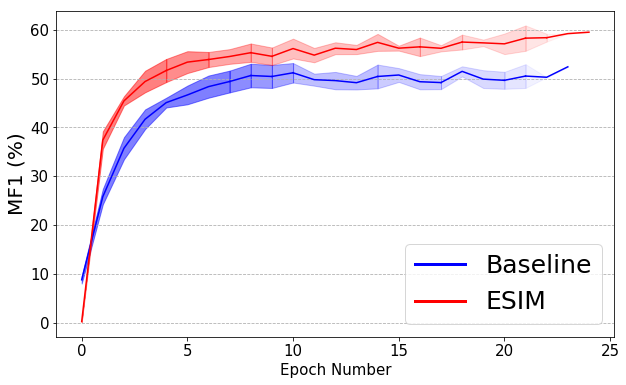

In [245]:
relevant_settings = ['N']
models_colours = {'Baseline': 'blue', 'ESIM': 'red'}
models_val     = {'Baseline': dict_test_B_SO_val, 'ESIM': dict_test_E_SO_val}

fig, ax = plt.subplots(figsize=(10,6))#plt.figure(figsize=(10,8))

lines  = []
labels = []
for model in models_colours:
    lines.append(Line2D([0], [0], color=models_colours[model], linewidth=3, linestyle='-'))
    labels.append(model)

for model in models_colours:
    x = list(range(0, max(len(models_val[model]['N'][fold][0].epoch_history_x) for fold in models_val[model]['N'])))

    num_steps  = []
    mean       = []
    variance   = []
    fold_count = []
    fold_count_step = []
    for step in x:
        num_folds = sum(True for fold in models_val[model]['N'] if step in models_val[model]['N'][fold][0].epoch_history_x)
        if (bool(fold_count) and num_folds < fold_count[-1]):
            fold_count_step.append(step)
        fold_count.append(num_folds)
        values = np.array([models_val[model]['N'][fold][0].epoch_history[step] for fold in models_val[model]['N']
                                                                                   if step in models_val[model]['N'][fold][0].epoch_history_x])
        mean.append(np.average(values))
        variance.append(np.std(values))

    fold_count_step = [0] + fold_count_step + [x[-1] + 1]
    fold_count_step = list(zip(fold_count_step, fold_count_step[1:]))

    fold_count = list(set(fold_count))
    fold_count.sort(reverse=True)

    for i, (start, end) in enumerate(fold_count_step):
        if (i > 0):
            start -= 1
        plt.plot(x[start:end], mean[start:end], color=models_colours[model])
        plt.fill_between(np.array(x[start:end]), np.maximum(0, np.array(mean[start:end])-np.array(variance[start:end])),
                         np.array(mean[start:end])+np.array(variance[start:end]), color=models_colours[model], alpha=0.05*fold_count[i])


plt.ylabel('MF1 (%)', fontsize=20)
plt.xlabel('Epoch Number', fontsize=15)
ax.tick_params(axis = 'both', which = 'both', labelsize = 15)
plt.grid(linestyle='--', axis='y')

plt.legend(lines,labels, loc='lower right', prop={'size': 25})

fig = plt.gcf()
plt.show()
fig.savefig('../../Thesis Document/Code/Images/NL_val_evolution.pdf', bbox_inches='tight')

In [86]:
other_model    = {'Baseline': 'ESIM', 'ESIM': 'Baseline'}
models_results = {'Baseline': {'all': df_test_B_SO[relevant_settings], 'mean': def_test_B_SO_mean[relevant_settings], 'std':def_test_B_SO_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO[relevant_settings], 'mean': def_test_E_SO_mean[relevant_settings], 'std':def_test_E_SO_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c}" + "\n"
latex_header += r"Model & NL   \\ \hline" + "\n"


latex_body = r""

for l_num, model in enumerate(models_results):

    latex_body += r"{} & ".format(model)
    for setting_num, setting in enumerate(relevant_settings):
        mean_len = max(len(str(int(math.modf(models_results[_model]['mean'][setting])[1]))) for _model in models_results)
        std_len  = max(len(str(int(math.modf(models_results[_model]['std'][setting])[1]))) for _model in models_results)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[other_model[model]]['all'][setting].stack())
        significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (setting_num + 1 < len(relevant_settings)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{FE - Comparison of Baseline and ESIM for the NL Setting}" + "\n"
latex_footer += r"\label{tab:FE-Comparison-of-Baseline-and-ESIM-for-the-NL-Setting}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for the \ac{FE} dataset and the \ac{NL} setting, the MF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS). Bold face results indicate the best result, with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c}
Model & NL   \\ \hline
Baseline & 54.92 $\pm$ 1.15 \\
ESIM & \textbf{59.05 $\pm$ 2.52} \\
\end{tabular}
\caption{FE - Comparison of Baseline and ESIM for the NL Setting}
\label{tab:FE-Comparison-of-Baseline-and-ESIM-for-the-NL-Setting}
\medskip
\small
This table shows, for the \ac{FE} dataset and the \ac{NL} setting, the MF1 scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS). Bold face results indicate the best result, with two-tailed t-test statistical significance, at a p-value of 0.05.
\end{table}



#### Any-Shot Learning

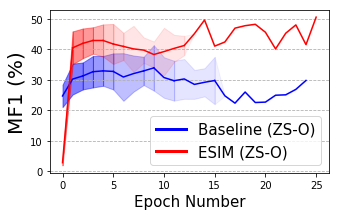

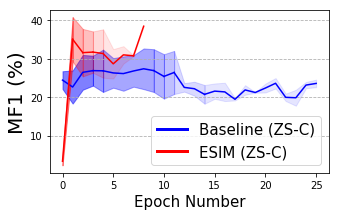

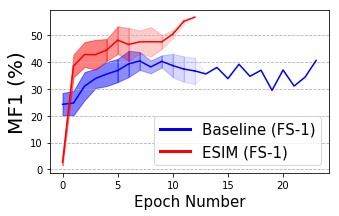

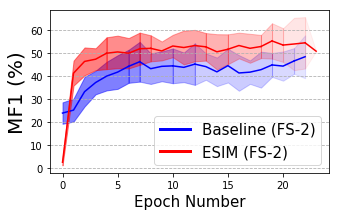

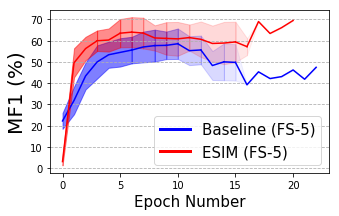

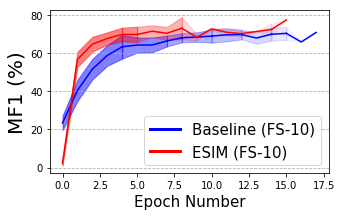

In [250]:
relevant_settings = ['ZS-O', 'ZS-C', 'FS-1', 'FS-2', 'FS-5', 'FS-10']
models_colours = {'Baseline': 'blue', 'ESIM': 'red'}
# models_colours = {'Baseline': {'ZS-C': 'deepskyblue', 'FS-1': 'dodgerblue', 'FS-2': 'blue', 'FS-5': 'mediumblue', 'FS-10': 'darkblue'},
#                   'ESIM'    : {'ZS-C': 'salmon', 'FS-1': 'tomato', 'FS-2': 'red', 'FS-5': 'firebrick', 'FS-10': 'darkred'}}
models_val     = {'Baseline': dict_test_B_SO_val, 'ESIM': dict_test_E_SO_val}


for setting in relevant_settings:
    fig, ax = plt.subplots(figsize=(5,3))

    lines  = []
    labels = []
    for model in models_colours:
        lines.append(Line2D([0], [0], color=models_colours[model], linewidth=3, linestyle='-'))
        labels.append(model + ' (' + setting + ')')

    for model in models_colours:
        x = list(range(0, max(len(models_val[model][setting][fold][0].epoch_history_x) for fold in models_val[model][setting])))

        num_steps  = []
        mean       = []
        variance   = []
        fold_count = []
        fold_count_step = []
        for step in x:
            num_folds = sum(True for fold in models_val[model][setting] if step in models_val[model][setting][fold][0].epoch_history_x)
            if (bool(fold_count) and num_folds < fold_count[-1]):
                fold_count_step.append(step)
            fold_count.append(num_folds)
            values = np.array([models_val[model][setting][fold][0].epoch_history[step] for fold in models_val[model][setting]
                                                                                           if step in models_val[model][setting][fold][0].epoch_history_x])
            mean.append(np.average(values))
            variance.append(np.std(values))

        fold_count_step = [0] + fold_count_step + [x[-1] + 1]
        fold_count_step = list(zip(fold_count_step, fold_count_step[1:]))

        fold_count = list(set(fold_count))
        fold_count.sort(reverse=True)

        for i, (start, end) in enumerate(fold_count_step):
            if (i > 0):
                start -= 1
            plt.plot(x[start:end], mean[start:end], color=models_colours[model])
            plt.fill_between(np.array(x[start:end]), np.maximum(0, np.array(mean[start:end])-np.array(variance[start:end])),
                             np.array(mean[start:end])+np.array(variance[start:end]), color=models_colours[model], alpha=0.05*fold_count[i])


    plt.ylabel('MF1 (%)', fontsize=20)
    plt.xlabel('Epoch Number', fontsize=15)
    ax.tick_params(axis = 'both', which = 'both', labelsize = 10)
    plt.grid(linestyle='--', axis='y')
    plt.legend(lines,labels, loc='lower right', prop={'size': 15})

    fig = plt.gcf()
    plt.show()
    fig.savefig('../../Thesis Document/Code/Images/' + setting + '_val_evolution.pdf', bbox_inches='tight')

##### Model Comparison

In [215]:
relevant_settings = ['ZS-O', 'ZS-C']

other_model    = {'Baseline': 'ESIM', 'ESIM': 'Baseline'}
models_results = {'Baseline': {'all': df_test_B_SO[relevant_settings], 'mean': def_test_B_SO_mean[relevant_settings], 'std':def_test_B_SO_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO[relevant_settings], 'mean': def_test_E_SO_mean[relevant_settings], 'std':def_test_E_SO_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|}" + "\n"
latex_header += r"Model & ZSL-O & ZSL-C \\ \hline" + "\n"


latex_body = r""

for l_num, model in enumerate(models_results):

    latex_body += r"{} & ".format(model)
    for setting_num, setting in enumerate(relevant_settings):
        mean_len = max(len(str(int(math.modf(models_results[_model]['mean'][setting])[1]))) for _model in models_results)
        std_len  = max(len(str(int(math.modf(models_results[_model]['std'][setting])[1]))) for _model in models_results)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[other_model[model]]['all'][setting].stack())
        significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (setting_num + 1 < len(relevant_settings)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
# latex_footer += r"\caption{FE - Comparison of Baseline and ESIM for the ASL Settings}" + "\n"
# latex_footer += r"\label{tab:FE-Comparison-of-Baseline-and-ESIM-for-the-ASL-Settings}" + "\n"
# latex_footer += r"\medskip" + "\n"
# latex_footer += r"\small" + "\n"
# latex_footer += r"This table shows, for the \ac{FE} dataset and the \ac{ASL} settings, the MF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS). Bold face results indicate the best result, between both models, with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|}
Model & ZSL-O & ZSL-C \\ \hline
Baseline & 32.90 $\pm$ 3.87 & 23.90 $\pm$ 5.46 \\
ESIM & \textbf{39.35 $\pm$ 4.87} & \textbf{32.81 $\pm$ 5.51} \\
\end{tabular}
\end{table}



In [214]:
relevant_settings = ['FS-1', 'FS-2', 'FS-5', 'FS-10']

other_model    = {'Baseline': 'ESIM', 'ESIM': 'Baseline'}
models_results = {'Baseline': {'all': df_test_B_SO[relevant_settings], 'mean': def_test_B_SO_mean[relevant_settings], 'std':def_test_B_SO_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO[relevant_settings], 'mean': def_test_E_SO_mean[relevant_settings], 'std':def_test_E_SO_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|c|c|}" + "\n"
latex_header += r"      & \multicolumn{4}{c|}{FS} \\ \cline{2-5}" + "\n"
latex_header += r"Model & 1         & 2          & 5            & 10        \\ \hline" + "\n"


latex_body = r""

for l_num, model in enumerate(models_results):

    latex_body += r"{} & ".format(model)
    for setting_num, setting in enumerate(relevant_settings):
        mean_len = max(len(str(int(math.modf(models_results[_model]['mean'][setting])[1]))) for _model in models_results)
        std_len  = max(len(str(int(math.modf(models_results[_model]['std'][setting])[1]))) for _model in models_results)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[other_model[model]]['all'][setting].stack())
        significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (setting_num + 1 < len(relevant_settings)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{FE - Comparison of Baseline and ESIM for the FSL Settings}" + "\n"
latex_footer += r"\label{tab:FE-Comparison-of-Baseline-and-ESIM-for-the-FSL-Settings}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for the \ac{FE} dataset and the \ac{FSL} settings, the MF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS). Bold face results indicate the best result, between both models, with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|c|c|}
      & \multicolumn{4}{c|}{FS} \\ \cline{2-5}
Model & 1         & 2          & 5            & 10        \\ \hline
Baseline & 41.74 $\pm$ 4.48 & 46.39 $\pm$ 4.10 & 59.06 $\pm$ 7.42 & 67.31 $\pm$ 5.36 \\
ESIM & 44.01 $\pm$ 6.48 & \textbf{52.20 $\pm$ 6.76} & 63.54 $\pm$ 7.13 & 71.73 $\pm$ 4.42 \\
\end{tabular}
\caption{FE - Comparison of Baseline and ESIM for the FSL Settings}
\label{tab:FE-Comparison-of-Baseline-and-ESIM-for-the-FSL-Settings}
\medskip
\small
This table shows, for the \ac{FE} dataset and the \ac{FSL} settings, the MF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS). Bold face results indicate the best result, between both models, with two-tailed t-test statistical significance, at a p-value of 0.05.
\end{table}



##### Open vs Closed Sets Comparison

In [224]:
relevant_settings = ['ZS-O', 'ZS-C']

models_results = {'Baseline': {'all': df_test_B_SO[relevant_settings], 'mean': def_test_B_SO_mean[relevant_settings], 'std':def_test_B_SO_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO[relevant_settings], 'mean': def_test_E_SO_mean[relevant_settings], 'std':def_test_E_SO_std[relevant_settings]},}


relevant_models = ['Baseline', 'ESIM']

other_setting = {'ZS-O': 'ZS-C', 'ZS-C': 'ZS-O'}

models_results = {'Baseline': {'all': df_test_B_SO[relevant_settings], 'mean': def_test_B_SO_mean[relevant_settings], 'std':def_test_B_SO_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO[relevant_settings], 'mean': def_test_E_SO_mean[relevant_settings], 'std':def_test_E_SO_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|}" + "\n"
latex_header += r"          & \multicolumn{2}{c}{Model} \\ \cline{1-3}" + "\n"
latex_header += r"Framework & Baseline & ESIM \\ \hline" + "\n"


latex_body = r""

for l_num, setting in enumerate(other_setting):

    latex_body += r"{} & ".format("Open Set" if setting == 'ZS-O' else "Closed Set")
    for m_num, model in enumerate(relevant_models):
        mean_len = max(len(str(int(math.modf(models_results[model]['mean'][_setting])[1]))) for _setting in other_setting)
        std_len  = max(len(str(int(math.modf(models_results[model]['std'][_setting])[1]))) for _setting in other_setting)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[model]['all'][other_setting[setting]].stack())
        significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (m_num + 1 < len(relevant_models)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{FE - Comparison of ZSL Open and Closed Frameworks}" + "\n"
latex_footer += r"\label{tab:FE-Comparison-of-ZSL-Open-and-Closed-Frameworks}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for the \ac{FE} dataset, the MF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when comparing the \ac{ZSL} Open Set Framework to the \ac{ZSL} Closed Set Framework. Bold face results indicate the best result, between both frameworks, with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|}
          & \multicolumn{2}{c}{Model} \\ \cline{1-3}
Framework & Baseline & ESIM \\ \hline
Open Set & \textbf{32.90 $\pm$ 3.87} & \textbf{39.35 $\pm$ 4.87} \\
Closed Set & 23.90 $\pm$ 5.46 & 32.81 $\pm$ 5.51 \\
\end{tabular}
\caption{FE - Comparison of ZSL Open and Closed Frameworks}
\label{tab:FE-Comparison-of-ZSL-Open-and-Closed-Frameworks}
\medskip
\small
This table shows, for the \ac{FE} dataset, the MF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when comparing the \ac{ZSL} Open Set Framework to the \ac{ZSL} Closed Set Framework. Bold face results indicate the best result, between both frameworks, with two-tailed t-test statistical significance, at a p-value of 0.05.
\end{table}



##### Increasing the Shot Number

In [252]:
relevant_settings = ['ZS-C', 'FS-1', 'FS-2', 'FS-5', 'FS-10']

models_results = {'Baseline': {'all': df_test_B_SO[relevant_settings], 'mean': def_test_B_SO_mean[relevant_settings], 'std':def_test_B_SO_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO[relevant_settings], 'mean': def_test_E_SO_mean[relevant_settings], 'std':def_test_E_SO_std[relevant_settings]},}

relevant_models = ['Baseline', 'ESIM']

other_setting = {'ZS-C': None, 'FS-1': 'ZS-C', 'FS-2': 'FS-1', 'FS-5': 'FS-2', 'FS-10': 'FS-5'}

models_results = {'Baseline': {'all': df_test_B_SO[relevant_settings], 'mean': def_test_B_SO_mean[relevant_settings], 'std':def_test_B_SO_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO[relevant_settings], 'mean': def_test_E_SO_mean[relevant_settings], 'std':def_test_E_SO_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|}" + "\n"
latex_header += r"          & \multicolumn{2}{c}{Model} \\ \cline{1-3}" + "\n"
latex_header += r"Setting & Baseline & ESIM \\ \hline" + "\n"


latex_body = r""

for l_num, setting in enumerate(other_setting):
    if ((l_num + 1) % 2 == 0):
        latex_body += r"\rowcolor[HTML]{EFEFEF} " + "\n"
    latex_body += r"{} & ".format(setting)
    for m_num, model in enumerate(relevant_models):
        mean_len = max(len(str(int(math.modf(models_results[model]['mean'][_setting])[1]))) for _setting in other_setting)
        std_len  = max(len(str(int(math.modf(models_results[model]['std'][_setting])[1]))) for _setting in other_setting)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        if (setting == 'ZS-C'):
            significant = False
        else:
            significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[model]['all'][other_setting[setting]].stack())
            significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (m_num + 1 < len(relevant_models)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{FE - Increasing the Shot Number in ASL Settings}" + "\n"
latex_footer += r"\label{tab:FE-Increasing-the-Shot-Number-in-ASL-Settings}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for the \ac{FE} dataset, the MF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when Increasing the Shot Number in ASL Settings. Bold face results indicate the best result, between 2 consecutive and increasing Shot Numbers (e.g.: if FS-2 has statistically better results than FS-1, then FS-2 will be bold faced), with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|}
          & \multicolumn{2}{c}{Model} \\ \cline{1-3}
Setting & Baseline & ESIM \\ \hline
ZS-C & 23.90 $\pm$ 5.46 & 32.81 $\pm$ 5.51 \\
\rowcolor[HTML]{EFEFEF} 
FS-1 & \textbf{41.74 $\pm$ 4.48} & \textbf{44.01 $\pm$ 6.48} \\
FS-2 & \textbf{46.39 $\pm$ 4.10} & \textbf{52.20 $\pm$ 6.76} \\
\rowcolor[HTML]{EFEFEF} 
FS-5 & \textbf{59.06 $\pm$ 7.42} & \textbf{63.54 $\pm$ 7.13} \\
FS-10 & \textbf{67.31 $\pm$ 5.36} & \textbf{71.73 $\pm$ 4.42} \\
\end{tabular}
\caption{FE - Increasing the Shot Number in ASL Settings}
\label{tab:FE-Increasing-the-Shot-Number-in-ASL-Settings}
\medskip
\small
This table shows, for the \ac{FE} dataset, the MF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when Increasing the Shot Number in ASL Settings. Bold face results indicate the best result, between 2 consecutive and increasing Shot Numbers (e.g.: if FS-2 has statistically better results than FS-1, then FS-2 will be bold face

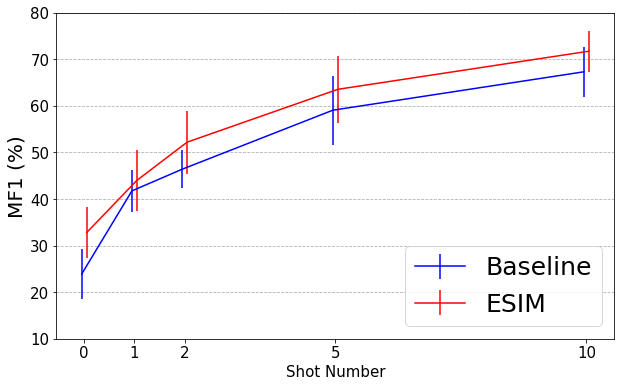

In [331]:
relevant_settings = ['ZS-C', 'FS-1', 'FS-2', 'FS-5', 'FS-10']

models_colours = {'Baseline': 'blue', 'ESIM': 'red'}
models_results = {'Baseline': {'all': df_test_B_SO[relevant_settings], 'mean': def_test_B_SO_mean[relevant_settings], 'std':def_test_B_SO_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO[relevant_settings], 'mean': def_test_E_SO_mean[relevant_settings], 'std':def_test_E_SO_std[relevant_settings]},}

relevant_models = ['Baseline', 'ESIM']

_min_y = min(models_results[model]['mean'][setting].item() - models_results[model]['std'][setting].item() for model in relevant_models for setting in relevant_settings)
_max_y = max(models_results[model]['mean'][setting].item() + models_results[model]['std'][setting].item() for model in relevant_models for setting in relevant_settings)

shot_to_setting = {0: 'ZS-C', 1: 'FS-1', 2: 'FS-2', 5: 'FS-5', 10: 'FS-10'}

fig = plt.figure(figsize=(10,6))

for m_num, model in enumerate(relevant_models):
    plt.errorbar([x + (-0.05 if m_num == 0 else 0.05) for x in [0, 1, 2, 5, 10]],
                 [models_results[model]['mean'][setting].item() for setting in relevant_settings],
                 yerr=[models_results[model]['std'][setting].item() for setting in relevant_settings],
                 label=model, color=models_colours[model])

plt.ylabel('MF1 (%)', fontsize=20)
plt.xlabel('Shot Number', fontsize=15)
plt.yticks(range(round_down(_min_y, 10), round_up(_max_y, 10), 10))
plt.xticks([0, 1, 2, 5, 10])
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'both', labelsize = 15)
plt.grid(linestyle='--', axis='y')

plt.legend(loc='lower right', prop={'size': 25})
fig = plt.gcf()
plt.show()
fig.savefig('../../Thesis Document/Code/Images/ASL_Increasing_Shot_Number.pdf', bbox_inches='tight')

#### Generalised Any-Shot Learning

##### HMF1

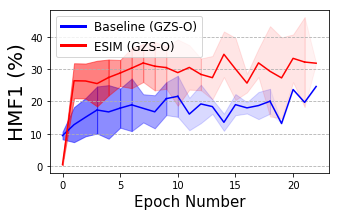

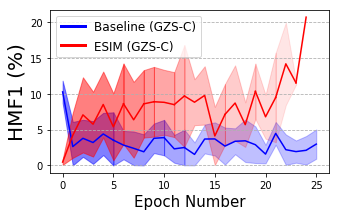

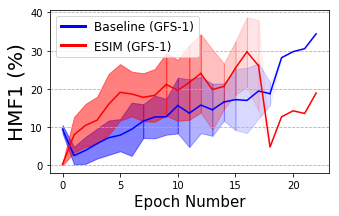

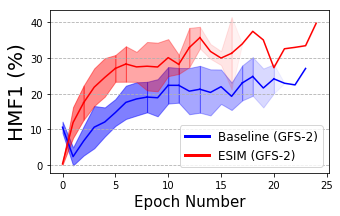

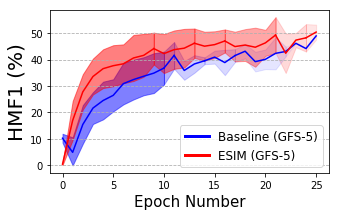

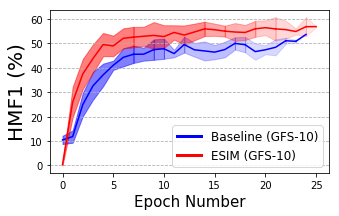

In [257]:
relevant_settings = ['GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']
models_colours = {'Baseline': 'blue', 'ESIM': 'red'}
# models_colours = {'Baseline': {'ZS-C': 'deepskyblue', 'FS-1': 'dodgerblue', 'FS-2': 'blue', 'FS-5': 'mediumblue', 'FS-10': 'darkblue'},
#                   'ESIM'    : {'ZS-C': 'salmon', 'FS-1': 'tomato', 'FS-2': 'red', 'FS-5': 'firebrick', 'FS-10': 'darkred'}}
models_val     = {'Baseline': dict_test_B_SO_val, 'ESIM': dict_test_E_SO_val}


for setting in relevant_settings:
    fig, ax = plt.subplots(figsize=(5,3))

    lines  = []
    labels = []
    for model in models_colours:
        lines.append(Line2D([0], [0], color=models_colours[model], linewidth=3, linestyle='-'))
        labels.append(model + ' (' + setting + ')')

    for model in models_colours:
        x = list(range(0, max(len(models_val[model][setting][fold][0].epoch_history_x) for fold in models_val[model][setting])))

        num_steps  = []
        mean       = []
        variance   = []
        fold_count = []
        fold_count_step = []
        for step in x:
            num_folds = sum(True for fold in models_val[model][setting] if step in models_val[model][setting][fold][0].epoch_history_x)
            if (bool(fold_count) and num_folds < fold_count[-1]):
                fold_count_step.append(step)
            fold_count.append(num_folds)
            values = np.array([models_val[model][setting][fold][0].epoch_history[step] for fold in models_val[model][setting]
                                                                                           if step in models_val[model][setting][fold][0].epoch_history_x])
            mean.append(np.average(values))
            variance.append(np.std(values))

        fold_count_step = [0] + fold_count_step + [x[-1] + 1]
        fold_count_step = list(zip(fold_count_step, fold_count_step[1:]))

        fold_count = list(set(fold_count))
        fold_count.sort(reverse=True)

        for i, (start, end) in enumerate(fold_count_step):
            if (i > 0):
                start -= 1
            plt.plot(x[start:end], mean[start:end], color=models_colours[model])
            plt.fill_between(np.array(x[start:end]), np.maximum(0, np.array(mean[start:end])-np.array(variance[start:end])),
                             np.array(mean[start:end])+np.array(variance[start:end]), color=models_colours[model], alpha=0.05*fold_count[i])


    plt.ylabel('HMF1 (%)', fontsize=20)
    plt.xlabel('Epoch Number', fontsize=15)
    ax.tick_params(axis = 'both', which = 'both', labelsize = 10)
    plt.grid(linestyle='--', axis='y')
    plt.legend(lines,labels, loc='upper left' if setting in ['GZS-O', 'GZS-C', 'GFS-1'] else 'lower right', prop={'size': 12})

    fig = plt.gcf()
    plt.show()
    fig.savefig('../../Thesis Document/Code/Images/' + setting + '_val_evolution.pdf', bbox_inches='tight')

##### MF1 on Seen and Unseen Sets

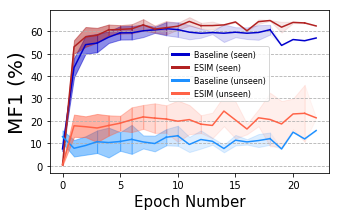

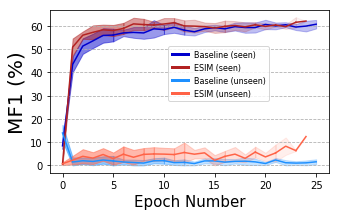

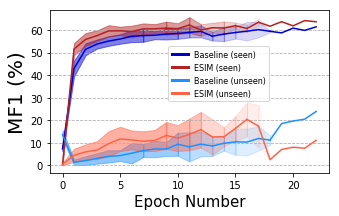

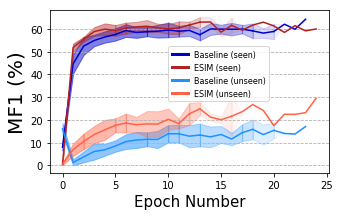

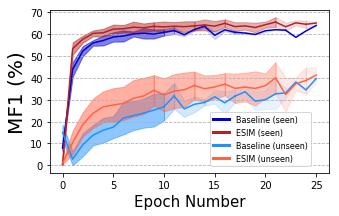

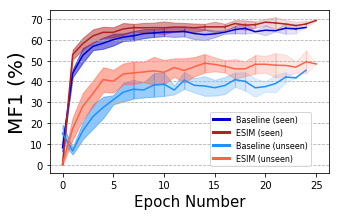

In [285]:
seen_unseen = ['seen', 'unseen']
relevant_settings = ['GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']
# models_colours = {'Baseline': 'blue', 'ESIM': 'red'}
models_colours = {'Baseline': {'seen': 'mediumblue', 'unseen': 'dodgerblue'}, 'ESIM': {'seen': 'firebrick', 'unseen': 'tomato'}}
# models_colours = {'Baseline': {'ZS-C': 'deepskyblue', 'FS-1': 'dodgerblue', 'FS-2': 'blue', 'FS-5': 'mediumblue', 'FS-10': 'darkblue'},
#                   'ESIM'    : {'ZS-C': 'salmon', 'FS-1': 'tomato', 'FS-2': 'red', 'FS-5': 'firebrick', 'FS-10': 'darkred'}}.seen_unseen_MacroF1['seen']
models_val     = {'Baseline': dict_test_B_SO_val, 'ESIM': dict_test_E_SO_val}

for setting in relevant_settings:
    fig, ax = plt.subplots(figsize=(5,3))

    lines  = []
    labels = []

    for s_u in seen_unseen:
        for model in models_colours:
            lines.append(Line2D([0], [0], color=models_colours[model][s_u], linewidth=3, linestyle='-'))
            labels.append(model + ' (' +  s_u + ')')

        for model in models_colours:
            x = list(range(0, max(len(models_val[model][setting][fold][0].seen_unseen_MacroF1[s_u].epoch_history_x) for fold in models_val[model][setting])))

            num_steps  = []
            mean       = []
            variance   = []
            fold_count = []
            fold_count_step = []
            for step in x:
                num_folds = sum(True for fold in models_val[model][setting] if step in models_val[model][setting][fold][0].epoch_history_x)
                if (bool(fold_count) and num_folds < fold_count[-1]):
                    fold_count_step.append(step)
                fold_count.append(num_folds)
                values = np.array([models_val[model][setting][fold][0].seen_unseen_MacroF1[s_u].epoch_history[step] for fold in models_val[model][setting]
                                                                                               if step in models_val[model][setting][fold][0].epoch_history_x])
                mean.append(np.average(values))
                variance.append(np.std(values))

            fold_count_step = [0] + fold_count_step + [x[-1] + 1]
            fold_count_step = list(zip(fold_count_step, fold_count_step[1:]))

            fold_count = list(set(fold_count))
            fold_count.sort(reverse=True)

            for i, (start, end) in enumerate(fold_count_step):
                if (i > 0):
                    start -= 1
                plt.plot(x[start:end], mean[start:end], color=models_colours[model][s_u])
                plt.fill_between(np.array(x[start:end]), np.maximum(0, np.array(mean[start:end])-np.array(variance[start:end])),
                                 np.array(mean[start:end])+np.array(variance[start:end]), color=models_colours[model][s_u], alpha=0.05*fold_count[i])


    plt.ylabel('MF1 (%)', fontsize=20)
    plt.xlabel('Epoch Number', fontsize=15)
    ax.tick_params(axis = 'both', which = 'both', labelsize = 10)
    plt.grid(linestyle='--', axis='y')
    plt.legend(lines,labels, loc='best', prop={'size': 8}, bbox_to_anchor=((0.8,0.8) if setting in ['GZS-O', 'GZS-C', 'GFS-1', 'GFS-2'] else (0.95,0.4)))
    #'upper left' if setting in ['GZS-O', 'GZS-C', 'GFS-1'] else 'lower right'    (0.8,0.4)

    fig = plt.gcf()
    plt.show()
    fig.savefig('../../Thesis Document/Code/Images/' + setting + '_seen-unseen_val_evolution.pdf', bbox_inches='tight')

##### Model Comparison

In [306]:
# HMF1
relevant_settings = ['GZS-O', 'GZS-C']

other_model    = {'Baseline': 'ESIM', 'ESIM': 'Baseline'}
models_results = {'Baseline': {'all': df_test_B_SO[relevant_settings], 'mean': def_test_B_SO_mean[relevant_settings], 'std':def_test_B_SO_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO[relevant_settings], 'mean': def_test_E_SO_mean[relevant_settings], 'std':def_test_E_SO_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|}" + "\n"
latex_header += r"      & \multicolumn{2}{c}{\textit{Seen} \& \textit{Unseen} Classes (HMF1)} \\ \cline{1-3}" + "\n"
latex_header += r"Model & ZSL-O & ZSL-C \\ \hline" + "\n"


latex_body = r""

for l_num, model in enumerate(models_results):

    latex_body += r"{} & ".format(model)
    for setting_num, setting in enumerate(relevant_settings):
        mean_len = max(len(str(int(math.modf(models_results[_model]['mean'][setting])[1]))) for _model in models_results)
        std_len  = max(len(str(int(math.modf(models_results[_model]['std'][setting])[1]))) for _model in models_results)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[other_model[model]]['all'][setting].stack())
        significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (setting_num + 1 < len(relevant_settings)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
# latex_footer += r"\caption{FE - Comparison of Baseline and ESIM for the ASL Settings}" + "\n"
# latex_footer += r"\label{tab:FE-Comparison-of-Baseline-and-ESIM-for-the-ASL-Settings}" + "\n"
# latex_footer += r"\medskip" + "\n"
# latex_footer += r"\small" + "\n"
# latex_footer += r"This table shows, for the \ac{FE} dataset and the \ac{ASL} settings, the MF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS). Bold face results indicate the best result, between both models, with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|}
      & \multicolumn{2}{c}{\textit{Seen} \& \textit{Unseen} Classes (HMF1)} \\ \cline{1-3}
Model & ZSL-O & ZSL-C \\ \hline
Baseline & 18.23 $\pm$ 5.40 & 2.06 $\pm$ 2.11 \\
ESIM & \textbf{28.54 $\pm$ 5.50} & \textbf{9.54 $\pm$ 4.29} \\
\end{tabular}
\end{table}



In [309]:
# MF1 Seen Classes
relevant_settings = ['GZS-O', 'GZS-C']

other_model    = {'Baseline': 'ESIM', 'ESIM': 'Baseline'}
models_results = {'Baseline': {'all': df_test_B_SO_generalised_seen[relevant_settings],
                               'mean': def_test_B_SO_generalised_seen_mean[relevant_settings],
                               'std':def_test_B_SO_generalised_seen_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO_generalised_seen[relevant_settings],
                           'mean': def_test_E_SO_generalised_seen_mean[relevant_settings],
                           'std':def_test_E_SO_generalised_seen_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|}" + "\n"
latex_header += r"      & \multicolumn{2}{c}{\textit{Seen} Classes (MF1)} \\ \cline{1-3}" + "\n"
latex_header += r"Model & GZSL-O & GZSL-C \\ \hline" + "\n"


latex_body = r""

for l_num, model in enumerate(models_results):

    latex_body += r"{} & ".format(model)
    for setting_num, setting in enumerate(relevant_settings):
        mean_len = max(len(str(int(math.modf(models_results[_model]['mean'][setting])[1]))) for _model in models_results)
        std_len  = max(len(str(int(math.modf(models_results[_model]['std'][setting])[1]))) for _model in models_results)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[other_model[model]]['all'][setting].stack())
        significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (setting_num + 1 < len(relevant_settings)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
# latex_footer += r"\caption{FE - Comparison of Baseline and ESIM for the ASL Settings}" + "\n"
# latex_footer += r"\label{tab:FE-Comparison-of-Baseline-and-ESIM-for-the-ASL-Settings}" + "\n"
# latex_footer += r"\medskip" + "\n"
# latex_footer += r"\small" + "\n"
# latex_footer += r"This table shows, for the \ac{FE} dataset and the \ac{ASL} settings, the MF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS). Bold face results indicate the best result, between both models, with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|}
      & \multicolumn{2}{c}{\textit{Seen} Classes (MF1)} \\ \cline{1-3}
Model & GZSL-O & GZSL-C \\ \hline
Baseline & 57.72 $\pm$ 1.80 & 54.57 $\pm$ 2.14 \\
ESIM & 58.36 $\pm$ 2.00 & \textbf{56.81 $\pm$ 1.93} \\
\end{tabular}
\end{table}



In [310]:
# MF1 Unseen Classes
relevant_settings = ['GZS-O', 'GZS-C']

other_model    = {'Baseline': 'ESIM', 'ESIM': 'Baseline'}
models_results = {'Baseline': {'all': df_test_B_SO_generalised_unseen[relevant_settings],
                               'mean': def_test_B_SO_generalised_unseen_mean[relevant_settings],
                               'std':def_test_B_SO_generalised_unseen_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO_generalised_unseen[relevant_settings],
                           'mean': def_test_E_SO_generalised_unseen_mean[relevant_settings],
                           'std':def_test_E_SO_generalised_unseen_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|}" + "\n"
latex_header += r"      & \multicolumn{2}{c}{\textit{Unseen} Classes (MF1)} \\ \cline{1-3}" + "\n"
latex_header += r"Model & GZSL-O & GZSL-C \\ \hline" + "\n"


latex_body = r""

for l_num, model in enumerate(models_results):

    latex_body += r"{} & ".format(model)
    for setting_num, setting in enumerate(relevant_settings):
        mean_len = max(len(str(int(math.modf(models_results[_model]['mean'][setting])[1]))) for _model in models_results)
        std_len  = max(len(str(int(math.modf(models_results[_model]['std'][setting])[1]))) for _model in models_results)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[other_model[model]]['all'][setting].stack())
        significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (setting_num + 1 < len(relevant_settings)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
# latex_footer += r"\caption{FE - Comparison of Baseline and ESIM for the ASL Settings}" + "\n"
# latex_footer += r"\label{tab:FE-Comparison-of-Baseline-and-ESIM-for-the-ASL-Settings}" + "\n"
# latex_footer += r"\medskip" + "\n"
# latex_footer += r"\small" + "\n"
# latex_footer += r"This table shows, for the \ac{FE} dataset and the \ac{ASL} settings, the MF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS). Bold face results indicate the best result, between both models, with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|}
      & \multicolumn{2}{c}{\textit{Unseen} Classes (MF1)} \\ \cline{1-3}
Model & GZSL-O & GZSL-C \\ \hline
Baseline & 11.03 $\pm$ 3.99 & 1.07 $\pm$ 1.12 \\
ESIM & \textbf{19.15 $\pm$ 4.81} & \textbf{5.30 $\pm$ 2.53} \\
\end{tabular}
\end{table}



In [311]:
# HMF1
relevant_settings = ['GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']

other_model    = {'Baseline': 'ESIM', 'ESIM': 'Baseline'}
models_results = {'Baseline': {'all': df_test_B_SO[relevant_settings], 'mean': def_test_B_SO_mean[relevant_settings], 'std':def_test_B_SO_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO[relevant_settings], 'mean': def_test_E_SO_mean[relevant_settings], 'std':def_test_E_SO_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|c|c|}" + "\n"
latex_header += r"      & \multicolumn{4}{c}{\textit{Seen} \& \textit{Unseen} Classes (HMF1)} \\ \cline{1-5}" + "\n"
latex_header += r"      & \multicolumn{4}{c}{GFS} \\ \cline{2-5}" + "\n"
latex_header += r"Model & 1         & 2          & 5            & 10        \\ \hline" + "\n"


latex_body = r""

for l_num, model in enumerate(models_results):

    latex_body += r"{} & ".format(model)
    for setting_num, setting in enumerate(relevant_settings):
        mean_len = max(len(str(int(math.modf(models_results[_model]['mean'][setting])[1]))) for _model in models_results)
        std_len  = max(len(str(int(math.modf(models_results[_model]['std'][setting])[1]))) for _model in models_results)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[other_model[model]]['all'][setting].stack())
        significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (setting_num + 1 < len(relevant_settings)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
# latex_footer += r"\caption{FE - Comparison of Baseline and ESIM for the ASL Settings}" + "\n"
# latex_footer += r"\label{tab:FE-Comparison-of-Baseline-and-ESIM-for-the-ASL-Settings}" + "\n"
# latex_footer += r"\medskip" + "\n"
# latex_footer += r"\small" + "\n"
# latex_footer += r"This table shows, for the \ac{FE} dataset and the \ac{ASL} settings, the MF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS). Bold face results indicate the best result, between both models, with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|c|c|}
      & \multicolumn{4}{c}{\textit{Seen} \& \textit{Unseen} Classes (HMF1)} \\ \cline{2-5}
      & \multicolumn{4}{c}{GFS} \\ \cline{2-5}
Model & 1         & 2          & 5            & 10        \\ \hline
Baseline & 13.58 $\pm$ 4.12 & 23.29 $\pm$ 3.69 & 34.80 $\pm$ 6.52 & 48.13 $\pm$ 4.65 \\
ESIM & \textbf{22.74 $\pm$ 5.86} & \textbf{29.84 $\pm$ 5.16} & \textbf{45.64 $\pm$ 5.47} & \textbf{56.73 $\pm$ 3.74} \\
\end{tabular}
\end{table}



In [312]:
# MF1 Seen Classes
relevant_settings = ['GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']

other_model    = {'Baseline': 'ESIM', 'ESIM': 'Baseline'}
models_results = {'Baseline': {'all': df_test_B_SO_generalised_seen[relevant_settings],
                               'mean': def_test_B_SO_generalised_seen_mean[relevant_settings],
                               'std':def_test_B_SO_generalised_seen_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO_generalised_seen[relevant_settings],
                           'mean': def_test_E_SO_generalised_seen_mean[relevant_settings],
                           'std':def_test_E_SO_generalised_seen_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|c|c|}" + "\n"
latex_header += r"      & \multicolumn{4}{c}{\textit{Seen} Classes (MF1)} \\ \cline{1-5}" + "\n"
latex_header += r"      & \multicolumn{4}{c}{GFS} \\ \cline{2-5}" + "\n"
latex_header += r"Model & 1         & 2          & 5            & 10        \\ \hline" + "\n"


latex_body = r""

for l_num, model in enumerate(models_results):

    latex_body += r"{} & ".format(model)
    for setting_num, setting in enumerate(relevant_settings):
        mean_len = max(len(str(int(math.modf(models_results[_model]['mean'][setting])[1]))) for _model in models_results)
        std_len  = max(len(str(int(math.modf(models_results[_model]['std'][setting])[1]))) for _model in models_results)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[other_model[model]]['all'][setting].stack())
        significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (setting_num + 1 < len(relevant_settings)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
# latex_footer += r"\caption{FE - Comparison of Baseline and ESIM for the ASL Settings}" + "\n"
# latex_footer += r"\label{tab:FE-Comparison-of-Baseline-and-ESIM-for-the-ASL-Settings}" + "\n"
# latex_footer += r"\medskip" + "\n"
# latex_footer += r"\small" + "\n"
# latex_footer += r"This table shows, for the \ac{FE} dataset and the \ac{ASL} settings, the MF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS). Bold face results indicate the best result, between both models, with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|c|c|}
      & \multicolumn{4}{c}{\textit{Seen} Classes (MF1)} \\ \cline{2-5}
      & \multicolumn{4}{c}{GFS} \\ \cline{2-5}
Model & 1         & 2          & 5            & 10        \\ \hline
Baseline & 55.32 $\pm$ 1.99 & 56.06 $\pm$ 2.64 & 57.17 $\pm$ 3.03 & 59.32 $\pm$ 2.52 \\
ESIM & \textbf{58.04 $\pm$ 1.94} & 57.91 $\pm$ 2.24 & \textbf{61.24 $\pm$ 2.36} & \textbf{63.84 $\pm$ 2.60} \\
\end{tabular}
\end{table}



In [313]:
# MF1 Unseen Classes
relevant_settings = ['GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']

other_model    = {'Baseline': 'ESIM', 'ESIM': 'Baseline'}
models_results = {'Baseline': {'all': df_test_B_SO_generalised_unseen[relevant_settings],
                               'mean': def_test_B_SO_generalised_unseen_mean[relevant_settings],
                               'std':def_test_B_SO_generalised_unseen_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO_generalised_unseen[relevant_settings],
                           'mean': def_test_E_SO_generalised_unseen_mean[relevant_settings],
                           'std':def_test_E_SO_generalised_unseen_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|c|c|}" + "\n"
latex_header += r"      & \multicolumn{4}{c}{\textit{Unseen} Classes (MF1)} \\ \cline{1-5}" + "\n"
latex_header += r"      & \multicolumn{4}{c}{GFS} \\ \cline{2-5}" + "\n"
latex_header += r"Model & 1         & 2          & 5            & 10        \\ \hline" + "\n"


latex_body = r""

for l_num, model in enumerate(models_results):

    latex_body += r"{} & ".format(model)
    for setting_num, setting in enumerate(relevant_settings):
        mean_len = max(len(str(int(math.modf(models_results[_model]['mean'][setting])[1]))) for _model in models_results)
        std_len  = max(len(str(int(math.modf(models_results[_model]['std'][setting])[1]))) for _model in models_results)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[other_model[model]]['all'][setting].stack())
        significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (setting_num + 1 < len(relevant_settings)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
# latex_footer += r"\caption{FE - Comparison of Baseline and ESIM for the ASL Settings}" + "\n"
# latex_footer += r"\label{tab:FE-Comparison-of-Baseline-and-ESIM-for-the-ASL-Settings}" + "\n"
# latex_footer += r"\medskip" + "\n"
# latex_footer += r"\small" + "\n"
# latex_footer += r"This table shows, for the \ac{FE} dataset and the \ac{ASL} settings, the MF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS). Bold face results indicate the best result, between both models, with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|c|c|}
      & \multicolumn{4}{c}{\textit{Unseen} Classes (MF1)} \\ \cline{2-5}
      & \multicolumn{4}{c}{GFS} \\ \cline{2-5}
Model & 1         & 2          & 5            & 10        \\ \hline
Baseline & ~7.85 $\pm$ 2.63 & 14.78 $\pm$ 2.95 & 25.41 $\pm$ 6.56 & 40.68 $\pm$ 5.64 \\
ESIM & \textbf{14.37 $\pm$ 4.46} & \textbf{20.30 $\pm$ 4.43} & \textbf{36.78 $\pm$ 6.73} & \textbf{51.23 $\pm$ 5.18} \\
\end{tabular}
\end{table}



##### Open vs Closed Sets Comparison

In [316]:
relevant_settings = ['GZS-O', 'GZS-C']

models_results = {'Baseline': {'all': df_test_B_SO[relevant_settings], 'mean': def_test_B_SO_mean[relevant_settings], 'std':def_test_B_SO_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO[relevant_settings], 'mean': def_test_E_SO_mean[relevant_settings], 'std':def_test_E_SO_std[relevant_settings]},}


relevant_models = ['Baseline', 'ESIM']

other_setting = {'GZS-O': 'GZS-C', 'GZS-C': 'GZS-O'}

models_results = {'Baseline': {'all': df_test_B_SO[relevant_settings], 'mean': def_test_B_SO_mean[relevant_settings], 'std':def_test_B_SO_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO[relevant_settings], 'mean': def_test_E_SO_mean[relevant_settings], 'std':def_test_E_SO_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|}" + "\n"
latex_header += r"          & \multicolumn{2}{c}{\textit{Seen} \& \textit{Unseen} Classes (HMF1)} \\" + "\n"
latex_header += r"          & \multicolumn{2}{c}{Model} \\ \cline{1-3}" + "\n"
latex_header += r"Framework & Baseline & ESIM \\ \hline" + "\n"


latex_body = r""

for l_num, setting in enumerate(other_setting):

    latex_body += r"{} & ".format("Open Set" if setting == 'GZS-O' else "Closed Set")
    for m_num, model in enumerate(relevant_models):
        mean_len = max(len(str(int(math.modf(models_results[model]['mean'][_setting])[1]))) for _setting in other_setting)
        std_len  = max(len(str(int(math.modf(models_results[model]['std'][_setting])[1]))) for _setting in other_setting)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[model]['all'][other_setting[setting]].stack())
        significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (m_num + 1 < len(relevant_models)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{FE - Comparison of GZSL Open and Closed Frameworks}" + "\n"
latex_footer += r"\label{tab:FE-Comparison-of-GZSL-Open-and-Closed-Frameworks}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for the \ac{FE} dataset, the HMF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when comparing the \ac{GZSL} Open Set Framework to the \ac{GZSL} Closed Set Framework. Bold face results indicate the best result, between both frameworks, with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|}
          & \multicolumn{2}{c}{\textit{Seen} \& \textit{Unseen} Classes (HMF1)} \\
          & \multicolumn{2}{c}{Model} \\ \cline{1-3}
Framework & Baseline & ESIM \\ \hline
Open Set & \textbf{18.23 $\pm$ 5.40} & \textbf{28.54 $\pm$ 5.50} \\
Closed Set & ~2.06 $\pm$ 2.11 & ~9.54 $\pm$ 4.29 \\
\end{tabular}
\caption{FE - Comparison of GZSL Open and Closed Frameworks}
\label{tab:FE-Comparison-of-GZSL-Open-and-Closed-Frameworks}
\medskip
\small
This table shows, for the \ac{FE} dataset, the HMF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when comparing the \ac{GZSL} Open Set Framework to the \ac{GZSL} Closed Set Framework. Bold face results indicate the best result, between both frameworks, with two-tailed t-test statistical significance, at a p-value of 0.05.
\end{table}



In [317]:
# MF1 Seen Classes
relevant_settings = ['GZS-O', 'GZS-C']

relevant_models = ['Baseline', 'ESIM']

other_setting = {'GZS-O': 'GZS-C', 'GZS-C': 'GZS-O'}

other_model    = {'Baseline': 'ESIM', 'ESIM': 'Baseline'}
models_results = {'Baseline': {'all': df_test_B_SO_generalised_seen[relevant_settings],
                               'mean': def_test_B_SO_generalised_seen_mean[relevant_settings],
                               'std':def_test_B_SO_generalised_seen_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO_generalised_seen[relevant_settings],
                           'mean': def_test_E_SO_generalised_seen_mean[relevant_settings],
                           'std':def_test_E_SO_generalised_seen_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|}" + "\n"
latex_header += r"      & \multicolumn{2}{c}{\textit{Seen} Classes (MF1)} \\" + "\n"
latex_header += r"          & \multicolumn{2}{c}{Model} \\ \cline{1-3}" + "\n"
latex_header += r"Framework & Baseline & ESIM \\ \hline" + "\n"


latex_body = r""

for l_num, setting in enumerate(other_setting):

    latex_body += r"{} & ".format("Open Set" if setting == 'GZS-O' else "Closed Set")
    for m_num, model in enumerate(relevant_models):
        mean_len = max(len(str(int(math.modf(models_results[model]['mean'][_setting])[1]))) for _setting in other_setting)
        std_len  = max(len(str(int(math.modf(models_results[model]['std'][_setting])[1]))) for _setting in other_setting)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[model]['all'][other_setting[setting]].stack())
        significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (m_num + 1 < len(relevant_models)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{FE - Comparison of GZSL Open and Closed Frameworks}" + "\n"
latex_footer += r"\label{tab:FE-Comparison-of-GZSL-Open-and-Closed-Frameworks}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for the \ac{FE} dataset, the HMF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when comparing the \ac{GZSL} Open Set Framework to the \ac{GZSL} Closed Set Framework. Bold face results indicate the best result, between both frameworks, with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|}
      & \multicolumn{2}{c}{\textit{Seen} Classes (MF1)} \\
          & \multicolumn{2}{c}{Model} \\ \cline{1-3}
Framework & Baseline & ESIM \\ \hline
Open Set & \textbf{57.72 $\pm$ 1.80} & 58.36 $\pm$ 2.00 \\
Closed Set & 54.57 $\pm$ 2.14 & 56.81 $\pm$ 1.93 \\
\end{tabular}
\caption{FE - Comparison of GZSL Open and Closed Frameworks}
\label{tab:FE-Comparison-of-GZSL-Open-and-Closed-Frameworks}
\medskip
\small
This table shows, for the \ac{FE} dataset, the HMF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when comparing the \ac{GZSL} Open Set Framework to the \ac{GZSL} Closed Set Framework. Bold face results indicate the best result, between both frameworks, with two-tailed t-test statistical significance, at a p-value of 0.05.
\end{table}



In [318]:
# MF1 Unseen Classes
relevant_settings = ['GZS-O', 'GZS-C']

relevant_models = ['Baseline', 'ESIM']

other_setting = {'GZS-O': 'GZS-C', 'GZS-C': 'GZS-O'}

other_model    = {'Baseline': 'ESIM', 'ESIM': 'Baseline'}
models_results = {'Baseline': {'all': df_test_B_SO_generalised_unseen[relevant_settings],
                               'mean': def_test_B_SO_generalised_unseen_mean[relevant_settings],
                               'std':def_test_B_SO_generalised_unseen_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO_generalised_unseen[relevant_settings],
                           'mean': def_test_E_SO_generalised_unseen_mean[relevant_settings],
                           'std':def_test_E_SO_generalised_unseen_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|}" + "\n"
latex_header += r"      & \multicolumn{2}{c}{\textit{Unseen} Classes (MF1)} \\" + "\n"
latex_header += r"          & \multicolumn{2}{c}{Model} \\ \cline{1-3}" + "\n"
latex_header += r"Framework & Baseline & ESIM \\ \hline" + "\n"


latex_body = r""

for l_num, setting in enumerate(other_setting):

    latex_body += r"{} & ".format("Open Set" if setting == 'GZS-O' else "Closed Set")
    for m_num, model in enumerate(relevant_models):
        mean_len = max(len(str(int(math.modf(models_results[model]['mean'][_setting])[1]))) for _setting in other_setting)
        std_len  = max(len(str(int(math.modf(models_results[model]['std'][_setting])[1]))) for _setting in other_setting)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[model]['all'][other_setting[setting]].stack())
        significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (m_num + 1 < len(relevant_models)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{FE - Comparison of GZSL Open and Closed Frameworks}" + "\n"
latex_footer += r"\label{tab:FE-Comparison-of-GZSL-Open-and-Closed-Frameworks}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for the \ac{FE} dataset, the HMF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when comparing the \ac{GZSL} Open Set Framework to the \ac{GZSL} Closed Set Framework. Bold face results indicate the best result, between both frameworks, with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|}
      & \multicolumn{2}{c}{\textit{Unseen} Classes (MF1)} \\
          & \multicolumn{2}{c}{Model} \\ \cline{1-3}
Framework & Baseline & ESIM \\ \hline
Open Set & \textbf{11.03 $\pm$ 3.99} & \textbf{19.15 $\pm$ 4.81} \\
Closed Set & ~1.07 $\pm$ 1.12 & ~5.30 $\pm$ 2.53 \\
\end{tabular}
\caption{FE - Comparison of GZSL Open and Closed Frameworks}
\label{tab:FE-Comparison-of-GZSL-Open-and-Closed-Frameworks}
\medskip
\small
This table shows, for the \ac{FE} dataset, the HMF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when comparing the \ac{GZSL} Open Set Framework to the \ac{GZSL} Closed Set Framework. Bold face results indicate the best result, between both frameworks, with two-tailed t-test statistical significance, at a p-value of 0.05.
\end{table}



##### Increasing the Shot Number

In [321]:
# MHF1

relevant_settings = ['GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']

relevant_models = ['Baseline', 'ESIM']

other_setting = {'GZS-C': None, 'GFS-1': 'GZS-C', 'GFS-2': 'GFS-1', 'GFS-5': 'GFS-2', 'GFS-10': 'GFS-5'}

models_results = {'Baseline': {'all': df_test_B_SO[relevant_settings], 'mean': def_test_B_SO_mean[relevant_settings], 'std':def_test_B_SO_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO[relevant_settings], 'mean': def_test_E_SO_mean[relevant_settings], 'std':def_test_E_SO_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|}" + "\n"
latex_header += r"          & \multicolumn{2}{c}{\textit{Seen} \& \textit{Unseen} Classes (HMF1)} \\" + "\n"
latex_header += r"          & \multicolumn{2}{c}{Model} \\ \cline{1-3}" + "\n"
latex_header += r"Setting & Baseline & ESIM \\ \hline" + "\n"


latex_body = r""

for l_num, setting in enumerate(other_setting):
    if ((l_num + 1) % 2 == 0):
        latex_body += r"\rowcolor[HTML]{EFEFEF} " + "\n"
    latex_body += r"{} & ".format(setting)
    for m_num, model in enumerate(relevant_models):
        mean_len = max(len(str(int(math.modf(models_results[model]['mean'][_setting])[1]))) for _setting in other_setting)
        std_len  = max(len(str(int(math.modf(models_results[model]['std'][_setting])[1]))) for _setting in other_setting)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        if (setting == 'GZS-C'):
            significant = False
        else:
            significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[model]['all'][other_setting[setting]].stack())
            significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (m_num + 1 < len(relevant_models)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{FE - Increasing the Shot Number in GASL Settings}" + "\n"
latex_footer += r"\label{tab:FE-Increasing-the-Shot-Number-in-GASL-Settings}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for the \ac{FE} dataset, the HMF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when Increasing the Shot Number in GASL Settings. Bold face results indicate the best result, between 2 consecutive and increasing Shot Numbers (e.g.: if GFS-2 has statistically better results than GFS-1, then GFS-2 will be bold faced), with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|}
          & \multicolumn{2}{c}{\textit{Seen} \& \textit{Unseen} Classes (HMF1)} \\
          & \multicolumn{2}{c}{Model} \\ \cline{1-3}
Setting & Baseline & ESIM \\ \hline
GZS-C & ~2.06 $\pm$ 2.11 & ~9.54 $\pm$ 4.29 \\
\rowcolor[HTML]{EFEFEF} 
GFS-1 & \textbf{13.58 $\pm$ 4.12} & \textbf{22.74 $\pm$ 5.86} \\
GFS-2 & \textbf{23.29 $\pm$ 3.69} & \textbf{29.84 $\pm$ 5.16} \\
\rowcolor[HTML]{EFEFEF} 
GFS-5 & \textbf{34.80 $\pm$ 6.52} & \textbf{45.64 $\pm$ 5.47} \\
GFS-10 & \textbf{48.13 $\pm$ 4.65} & \textbf{56.73 $\pm$ 3.74} \\
\end{tabular}
\caption{FE - Increasing the Shot Number in GASL Settings}
\label{tab:FE-Increasing-the-Shot-Number-in-GASL-Settings}
\medskip
\small
This table shows, for the \ac{FE} dataset, the HMF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when Increasing the Shot Number in GASL Settings. Bold face results indicate the best result, between 2 consecutive and increasing Shot Nu

In [322]:
# MF1 Seen Classes

relevant_settings = ['GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']

relevant_models = ['Baseline', 'ESIM']

other_setting = {'GZS-C': None, 'GFS-1': 'GZS-C', 'GFS-2': 'GFS-1', 'GFS-5': 'GFS-2', 'GFS-10': 'GFS-5'}

models_results = {'Baseline': {'all': df_test_B_SO_generalised_seen[relevant_settings],
                               'mean': def_test_B_SO_generalised_seen_mean[relevant_settings],
                               'std':def_test_B_SO_generalised_seen_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO_generalised_seen[relevant_settings],
                           'mean': def_test_E_SO_generalised_seen_mean[relevant_settings],
                           'std':def_test_E_SO_generalised_seen_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|}" + "\n"
latex_header += r"        & \multicolumn{2}{c}{\textit{Seen} Classes (MF1)} \\" + "\n"
latex_header += r"        & \multicolumn{2}{c}{Model} \\ \cline{1-3}" + "\n"
latex_header += r"Setting & Baseline & ESIM \\ \hline" + "\n"


latex_body = r""

for l_num, setting in enumerate(other_setting):
    if ((l_num + 1) % 2 == 0):
        latex_body += r"\rowcolor[HTML]{EFEFEF} " + "\n"
    latex_body += r"{} & ".format(setting)
    for m_num, model in enumerate(relevant_models):
        mean_len = max(len(str(int(math.modf(models_results[model]['mean'][_setting])[1]))) for _setting in other_setting)
        std_len  = max(len(str(int(math.modf(models_results[model]['std'][_setting])[1]))) for _setting in other_setting)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        if (setting == 'GZS-C'):
            significant = False
        else:
            significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[model]['all'][other_setting[setting]].stack())
            significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (m_num + 1 < len(relevant_models)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{FE - Increasing the Shot Number in GASL Settings}" + "\n"
latex_footer += r"\label{tab:FE-Increasing-the-Shot-Number-in-GASL-Settings}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for the \ac{FE} dataset, the HMF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when Increasing the Shot Number in GASL Settings. Bold face results indicate the best result, between 2 consecutive and increasing Shot Numbers (e.g.: if GFS-2 has statistically better results than GFS-1, then GFS-2 will be bold faced), with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|}
        & \multicolumn{2}{c}{\textit{Seen} Classes (MF1)} \\
        & \multicolumn{2}{c}{Model} \\ \cline{1-3}
Setting & Baseline & ESIM \\ \hline
GZS-C & 54.57 $\pm$ 2.14 & 56.81 $\pm$ 1.93 \\
\rowcolor[HTML]{EFEFEF} 
GFS-1 & 55.32 $\pm$ 1.99 & 58.04 $\pm$ 1.94 \\
GFS-2 & 56.06 $\pm$ 2.64 & 57.91 $\pm$ 2.24 \\
\rowcolor[HTML]{EFEFEF} 
GFS-5 & 57.17 $\pm$ 3.03 & \textbf{61.24 $\pm$ 2.36} \\
GFS-10 & 59.32 $\pm$ 2.52 & \textbf{63.84 $\pm$ 2.60} \\
\end{tabular}
\caption{FE - Increasing the Shot Number in GASL Settings}
\label{tab:FE-Increasing-the-Shot-Number-in-GASL-Settings}
\medskip
\small
This table shows, for the \ac{FE} dataset, the HMF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when Increasing the Shot Number in GASL Settings. Bold face results indicate the best result, between 2 consecutive and increasing Shot Numbers (e.g.: if GFS-2 has statistically better results than GFS-1, then GFS-2 

In [323]:
# MF1 Unseen Classes

relevant_settings = ['GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']

relevant_models = ['Baseline', 'ESIM']

other_setting = {'GZS-C': None, 'GFS-1': 'GZS-C', 'GFS-2': 'GFS-1', 'GFS-5': 'GFS-2', 'GFS-10': 'GFS-5'}

models_results = {'Baseline': {'all': df_test_B_SO_generalised_unseen[relevant_settings],
                               'mean': def_test_B_SO_generalised_unseen_mean[relevant_settings],
                               'std':def_test_B_SO_generalised_unseen_std[relevant_settings]},
                  'ESIM': {'all': df_test_E_SO_generalised_unseen[relevant_settings],
                           'mean': def_test_E_SO_generalised_unseen_mean[relevant_settings],
                           'std':def_test_E_SO_generalised_unseen_std[relevant_settings]},}

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|}" + "\n"
latex_header += r"        & \multicolumn{2}{c}{\textit{Unseen} Classes (MF1)} \\" + "\n"
latex_header += r"        & \multicolumn{2}{c}{Model} \\ \cline{1-3}" + "\n"
latex_header += r"Setting & Baseline & ESIM \\ \hline" + "\n"


latex_body = r""

for l_num, setting in enumerate(other_setting):
    if ((l_num + 1) % 2 == 0):
        latex_body += r"\rowcolor[HTML]{EFEFEF} " + "\n"
    latex_body += r"{} & ".format(setting)
    for m_num, model in enumerate(relevant_models):
        mean_len = max(len(str(int(math.modf(models_results[model]['mean'][_setting])[1]))) for _setting in other_setting)
        std_len  = max(len(str(int(math.modf(models_results[model]['std'][_setting])[1]))) for _setting in other_setting)

        mean        = models_results[model]['mean'][setting][0]
        std         = models_results[model]['std'][setting][0]
        if (setting == 'GZS-C'):
            significant = False
        else:
            significant = ttest_ind(models_results[model]['all'][setting].stack(), models_results[model]['all'][other_setting[setting]].stack())
            significant = True if significant[0] > 0 and significant[1] < 0.05 else False

        if (significant):
            latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
        else:
            latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
        if (m_num + 1 < len(relevant_models)):
            latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{FE - Increasing the Shot Number in GASL Settings}" + "\n"
latex_footer += r"\label{tab:FE-Increasing-the-Shot-Number-in-GASL-Settings}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for the \ac{FE} dataset, the HMF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when Increasing the Shot Number in GASL Settings. Bold face results indicate the best result, between 2 consecutive and increasing Shot Numbers (e.g.: if GFS-2 has statistically better results than GFS-1, then GFS-2 will be bold faced), with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|}
        & \multicolumn{2}{c}{\textit{Seen} Classes (MF1)} \\
        & \multicolumn{2}{c}{Model} \\ \cline{1-3}
Setting & Baseline & ESIM \\ \hline
GZS-C & ~1.07 $\pm$ 1.12 & ~5.30 $\pm$ 2.53 \\
\rowcolor[HTML]{EFEFEF} 
GFS-1 & \textbf{~7.85 $\pm$ 2.63} & \textbf{14.37 $\pm$ 4.46} \\
GFS-2 & \textbf{14.78 $\pm$ 2.95} & \textbf{20.30 $\pm$ 4.43} \\
\rowcolor[HTML]{EFEFEF} 
GFS-5 & \textbf{25.41 $\pm$ 6.56} & \textbf{36.78 $\pm$ 6.73} \\
GFS-10 & \textbf{40.68 $\pm$ 5.64} & \textbf{51.23 $\pm$ 5.18} \\
\end{tabular}
\caption{FE - Increasing the Shot Number in GASL Settings}
\label{tab:FE-Increasing-the-Shot-Number-in-GASL-Settings}
\medskip
\small
This table shows, for the \ac{FE} dataset, the HMF1 test scores, in \%, for both our baseline and our \ac{ESIM} variant (ESIM\_StS) when Increasing the Shot Number in GASL Settings. Bold face results indicate the best result, between 2 consecutive and increasing Shot Numbers (e.g.: if GFS-2 ha

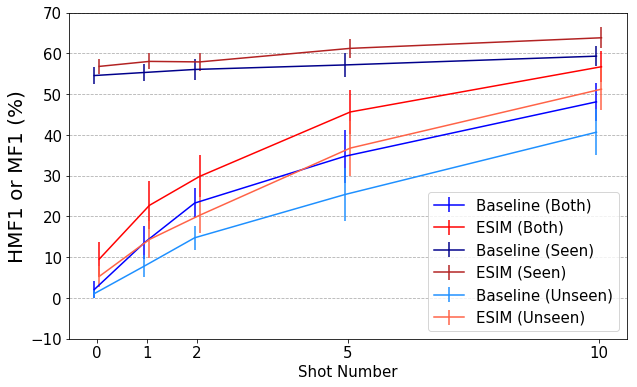

In [333]:
relevant_settings = ['GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']

relevant_models = ['Baseline', 'ESIM']

models_colours = {'Baseline': {'Seen': 'darkblue', 'Both': 'blue', 'Unseen': 'dodgerblue'},
                  'ESIM': {'Seen': 'firebrick', 'Both': 'red', 'Unseen': 'tomato'}}

models_results = {'Both'      : {'Baseline': {'all': df_test_B_SO[relevant_settings],
                                              'mean': def_test_B_SO_mean[relevant_settings],
                                              'std':def_test_B_SO_std[relevant_settings]},
                                 'ESIM': {'all': df_test_E_SO[relevant_settings],
                                          'mean': def_test_E_SO_mean[relevant_settings],
                                          'std':def_test_E_SO_std[relevant_settings]},},
                  'Seen'  : {'Baseline': {'all': df_test_B_SO_generalised_seen[relevant_settings],
                                              'mean': def_test_B_SO_generalised_seen_mean[relevant_settings],
                                              'std':def_test_B_SO_generalised_seen_std[relevant_settings]},
                                 'ESIM': {'all': df_test_E_SO_generalised_seen[relevant_settings],
                                          'mean': def_test_E_SO_generalised_seen_mean[relevant_settings],
                                          'std':def_test_E_SO_generalised_seen_std[relevant_settings]},},
                  'Unseen': {'Baseline': {'all': df_test_B_SO_generalised_unseen[relevant_settings],
                                              'mean': def_test_B_SO_generalised_unseen_mean[relevant_settings],
                                              'std':def_test_B_SO_generalised_unseen_std[relevant_settings]},
                                 'ESIM': {'all': df_test_E_SO_generalised_unseen[relevant_settings],
                                          'mean': def_test_E_SO_generalised_unseen_mean[relevant_settings],
                                          'std':def_test_E_SO_generalised_unseen_std[relevant_settings]},}
                 }

_min_y = min(models_results[s_u][model]['mean'][setting].item() - models_results[s_u][model]['std'][setting].item() for s_u in models_results
                                                                                                                        for model in relevant_models
                                                                                                                            for setting in relevant_settings)
_max_y = max(models_results[s_u][model]['mean'][setting].item() + models_results[s_u][model]['std'][setting].item() for s_u in models_results
                                                                                                                        for model in relevant_models
                                                                                                                            for setting in relevant_settings)

shot_to_setting = {0: 'ZS-C', 1: 'FS-1', 2: 'FS-2', 5: 'FS-5', 10: 'FS-10'}

fig = plt.figure(figsize=(10,6))

for s_num, s_u in enumerate(models_results):
    for m_num, model in enumerate(relevant_models):
        plt.errorbar([x + (-0.05 if m_num == 0 else 0.05) for x in [0, 1, 2, 5, 10]],
                     [models_results[s_u][model]['mean'][setting].item() for setting in relevant_settings],
                     yerr=[models_results[s_u][model]['std'][setting].item() for setting in relevant_settings],
                     label=model + ' (' + s_u + ')', color=models_colours[model][s_u])

plt.ylabel('HMF1 or MF1 (%)', fontsize=20)
plt.xlabel('Shot Number', fontsize=15)
plt.yticks(range(round_down(_min_y, 10), round_up(_max_y, 10), 10))
plt.xticks([0, 1, 2, 5, 10])
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'both', labelsize = 15)
plt.grid(linestyle='--', axis='y')

plt.legend(loc='lower right', prop={'size': 15})
fig = plt.gcf()
plt.show()
fig.savefig('../../Thesis Document/Code/Images/GASL_Increasing_Shot_Number.pdf', bbox_inches='tight')

##### Non-Generalised Case vs Generalised Case

In [346]:
relevant_settings = ['(G)ZS-O', '(G)ZS-C', '(G)FS-1', '(G)FS-2', '(G)FS-5', '(G)FS-10']

other_g = {'Non-G': 'G', 'G': 'Non-G'}

g_to_settings = {'Non-G': ['ZS-O', 'ZS-C', 'FS-1', 'FS-2', 'FS-5', 'FS-10'],
                'G'    : ['GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']}

g_setting_to_setting = {('Non-G', '(G)ZS-O') : 'ZS-O',  ('G', '(G)ZS-O'): 'GZS-O',
                        ('Non-G', '(G)ZS-C') : 'ZS-C',  ('G', '(G)ZS-C'): 'GZS-C',
                        ('Non-G', '(G)FS-1') : 'FS-1',  ('G', '(G)FS-1'): 'GFS-1',
                        ('Non-G', '(G)FS-2') : 'FS-2',  ('G', '(G)FS-2'): 'GFS-2',
                        ('Non-G', '(G)FS-5') : 'FS-5',  ('G', '(G)FS-5'): 'GFS-5',
                        ('Non-G', '(G)FS-10'): 'FS-10', ('G', '(G)FS-10'): 'GFS-10',}

relevant_models = ['Baseline', 'ESIM']

other_setting = {'ZS-O' : 'GZS-O',  'GZS-O' : 'ZS-O',
                 'ZS-C' : 'GZS-C',  'GZS-C' : 'ZS-C',
                 'FS-1' : 'GFS-1',  'GFS-1' : 'FS-1',
                 'FS-2' : 'GFS-2',  'GFS-2' : 'FS-2',
                 'FS-5' : 'GFS-5',  'GFS-5' : 'FS-5',
                 'FS-10': 'GFS-10', 'GFS-10': 'FS-10',}


models_results = {'Non-G': {'Baseline': {'all': df_test_B_SO[g_to_settings['Non-G']],
                                         'mean': def_test_B_SO_mean[g_to_settings['Non-G']],
                                         'std':def_test_B_SO_std[g_to_settings['Non-G']]},
                            'ESIM': {'all': df_test_E_SO[g_to_settings['Non-G']],
                                     'mean': def_test_E_SO_mean[g_to_settings['Non-G']],
                                     'std':def_test_E_SO_std[g_to_settings['Non-G']]},},
                  'G'    : {'Baseline': {'all': df_test_B_SO_generalised_unseen[g_to_settings['G']],
                                         'mean': def_test_B_SO_generalised_unseen_mean[g_to_settings['G']],
                                         'std':def_test_B_SO_generalised_unseen_std[g_to_settings['G']]},
                            'ESIM': {'all': df_test_E_SO_generalised_unseen[g_to_settings['G']],
                                     'mean': def_test_E_SO_generalised_unseen_mean[g_to_settings['G']],
                                     'std':def_test_E_SO_generalised_unseen_std[g_to_settings['G']]},}
                 }

latex_header = r"\begin{table}[h]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|c|c|}" + "\n"
latex_header += r"        & \multicolumn{4}{c}{Model} \\ \cline{1-5}" + "\n"
latex_header += r"        & \multicolumn{2}{c|}{Baseline}  & \multicolumn{2}{c|}{ESIM} \\ \hline" + "\n"
latex_header += r"Setting & Non-Generalised & Generalised & Non-Generalised & Generalised  \\ \hline" + "\n"


latex_body = r""

for l_num, setting in enumerate(relevant_settings):
    if ((l_num + 1) % 2 == 0):
        latex_body += r"\rowcolor[HTML]{EFEFEF} " + "\n"
    latex_body += r"{} & ".format(setting)
    for m_num, model in enumerate(relevant_models):
        for g in models_results:
            mean_len = max(len(str(int(math.modf(models_results[g][model]['mean'][_setting])[1]))) for _setting in g_to_settings[g])
            std_len  = max(len(str(int(math.modf(models_results[g][model]['std'][_setting])[1]))) for _setting in g_to_settings[g])

            mean        = models_results[g][model]['mean'][g_setting_to_setting[(g, setting)]][0]
            std         = models_results[g][model]['std'][g_setting_to_setting[(g, setting)]][0]

            significant = ttest_ind(models_results[g][model]['all'][g_setting_to_setting[(g, setting)]].stack(),
                                    models_results[other_g[g]][model]['all'][other_setting[g_setting_to_setting[(g, setting)]]].stack())
            significant = True if significant[0] > 0 and significant[1] < 0.05 else False

            if (significant):
                latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
            else:
                latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
            if (m_num == 0 or g == 'Non-G'):
                latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{FE - Comparing Performance on the \textit{unseen} Classes Between ASL and GASL}" + "\n"
latex_footer += r"\label{tab:FE-Comparing-Performance-on-the-unseen-Classes-Between-ASL-and-GASL}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for the \ac{FE} dataset, the comparison of MF1 test scores, in \%, between the \ac{ASL} and the \ac{GASL} settings, for both our baseline and our \ac{ESIM} variant (ESIM\_StS). Bold face results indicate the best result, between the Generalised and Non-Generalised cases (independently of the model), with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{c|c|c|c|c|}
        & \multicolumn{4}{c}{Model} \\ \cline{1-5}
        & \multicolumn{2}{c|}{Baseline}  & \multicolumn{2}{c|}{ESIM} \\ \hline
Setting & Non-Generalised & Generalised & Non-Generalised & Generalised  \\ \hline
(G)ZS-O & \textbf{32.90 $\pm$ 3.87} & 11.03 $\pm$ 3.99 & \textbf{39.35 $\pm$ 4.87} & 19.15 $\pm$ 4.81 \\
\rowcolor[HTML]{EFEFEF} 
(G)ZS-C & \textbf{23.90 $\pm$ 5.46} & ~1.07 $\pm$ 1.12 & \textbf{32.81 $\pm$ 5.51} & ~5.30 $\pm$ 2.53 \\
(G)FS-1 & \textbf{41.74 $\pm$ 4.48} & ~7.85 $\pm$ 2.63 & \textbf{44.01 $\pm$ 6.48} & 14.37 $\pm$ 4.46 \\
\rowcolor[HTML]{EFEFEF} 
(G)FS-2 & \textbf{46.39 $\pm$ 4.10} & 14.78 $\pm$ 2.95 & \textbf{52.20 $\pm$ 6.76} & 20.30 $\pm$ 4.43 \\
(G)FS-5 & \textbf{59.06 $\pm$ 7.42} & 25.41 $\pm$ 6.56 & \textbf{63.54 $\pm$ 7.13} & 36.78 $\pm$ 6.73 \\
\rowcolor[HTML]{EFEFEF} 
(G)FS-10 & \textbf{67.31 $\pm$ 5.36} & 40.68 $\pm$ 5.64 & \textbf{71.73 $\pm$ 4.42} & 51.23 $\pm$ 5.18 \\
\end{tabular}
\caption{FE

# -------------------------------------------------------------------------------------------------------

### Unmasked

In [16]:
saved_states = '..' + os.sep + 'saved_models_states'
dataset_type = 'final_evaluation'
config_ids = list(range(1))
model_type = 'ESIM_StS'
experiment_type = 'unmasked'
settings = ['N', 'ZS-O', 'ZS-C', 'FS-1', 'FS-2', 'FS-5', 'FS-10', 'GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']
folds = list(range(10))

selection_metric = {'N': 'MacroF1', 'ZS': 'MacroF1', 'GZS': 'HarmonicMacroF1', 'FS': 'MacroF1', 'GFS': 'HarmonicMacroF1'}

In [17]:
dict_test_E_U                    = {}
dict_test_E_U_generalised_seen   = {}
dict_test_E_U_generalised_unseen = {}
dict_test_E_U_val                = {}

for setting in settings:
    dict_test_E_U[setting]     = {}
    dict_test_E_U_val[setting] = {}
    if (setting[0] == 'G'):
        dict_test_E_U_generalised_seen[setting]   = {}
        dict_test_E_U_generalised_unseen[setting] = {}
    for fold in folds:
        dict_test_E_U[setting][fold]     = {}
        dict_test_E_U_val[setting][fold] = {}
        if (setting[0] == 'G'):
            dict_test_E_U_generalised_seen[setting][fold]   = {}
            dict_test_E_U_generalised_unseen[setting][fold] = {}
        for config_id in config_ids:
            mma_path = join_path([saved_states, dataset_type, model_type, 'config_' + str(config_id), experiment_type, setting,
                                  str(fold), 'saved_states', 'MMa' + os.sep])
            last_epoch = max([int(file.split('.')[-2]) for file in os.listdir(mma_path) if file.endswith('.ckp')])
            best_epoch = -1 if any([True for file in os.listdir(mma_path) if file.endswith('.bst')]) else last_epoch

            # TEST SCORES
            mma = MetricsManager(None, None, None, None, None, None, None, None, None, just_MMa=True, 
                                 load_path=join_path(get_path_components(mma_path)[:-1]) + os.sep, load_epoch_or_best=last_epoch)
            dict_test_E_U[setting][fold][config_id] = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).epoch_history[-1]
            if (setting[0] == 'G'):
                dict_test_E_U_generalised_seen[setting][fold][config_id]   = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).seen_unseen_MacroF1['seen'].epoch_history[-1]
                dict_test_E_U_generalised_unseen[setting][fold][config_id] = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).seen_unseen_MacroF1['unseen'].epoch_history[-1]

            # VALIDATION
            mma = MetricsManager(None, None, None, None, None, None, None, None, None, just_MMa=True, 
                                 load_path=join_path(get_path_components(mma_path)[:-1]) + os.sep, load_epoch_or_best=best_epoch)
            dict_test_E_U_val[setting][fold][config_id] = mma.get_specific_metric('val', selection_metric[setting.split('-')[0]])

In [19]:
df_test_E_U = dolphins.DataFrame.from_dict({(i,j): dict_test_E_U[i][j]
                                            for i in dict_test_E_U.keys()
                                            for j in dict_test_E_U[i].keys()},
                                           orient='columns')
df_test_E_U.index.set_names(['Configuration'], inplace=True)
df_test_E_U.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_E_U_mean = df_test_E_U.mean(axis=1, level=0)
def_test_E_U_std  = df_test_E_U.std(axis=1, level=0)


# Seen Classes
df_test_E_U_generalised_seen = dolphins.DataFrame.from_dict({(i,j): dict_test_E_U_generalised_seen[i][j]
                                                             for i in dict_test_E_U_generalised_seen.keys()
                                                             for j in dict_test_E_U_generalised_seen[i].keys()},
                                                            orient='columns')
df_test_E_U_generalised_seen.index.set_names(['Configuration'], inplace=True)
df_test_E_U_generalised_seen.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_E_U_generalised_seen_mean = df_test_E_U_generalised_seen.mean(axis=1, level=0)
def_test_E_U_generalised_seen_std  = df_test_E_U_generalised_seen.std(axis=1, level=0)


# Unseen Classes
df_test_E_U_generalised_unseen = dolphins.DataFrame.from_dict({(i,j): dict_test_E_U_generalised_unseen[i][j]
                                                                for i in dict_test_E_U_generalised_unseen.keys()
                                                                for j in dict_test_E_U_generalised_unseen[i].keys()},
                                                               orient='columns')
df_test_E_U_generalised_unseen.index.set_names(['Configuration'], inplace=True)
df_test_E_U_generalised_unseen.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_E_U_generalised_unseen_mean = df_test_E_U_generalised_unseen.mean(axis=1, level=0)
def_test_E_U_generalised_unseen_std  = df_test_E_U_generalised_unseen.std(axis=1, level=0)



print("BASELINE")
display(dolphins.concat([def_test_B_U_mean, def_test_B_U_std]))
print("ESIM")
display(dolphins.concat([def_test_E_U_mean, def_test_E_U_std]))


print("\n\n\n\GENERALISED CASES")
print("BASELINE")
with dolphins.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dolphins.concat([df_test_B_U[['GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']], df_test_B_U_generalised_seen, df_test_B_U_generalised_unseen]))
print("ESIM")
with dolphins.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dolphins.concat([df_test_E_U[['GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']], df_test_E_U_generalised_seen, df_test_E_U_generalised_unseen]))

BASELINE


Setting,N,ZS-O,ZS-C,FS-1,FS-2,FS-5,FS-10,GZS-O,GZS-C,GFS-1,GFS-2,GFS-5,GFS-10
Configuration,,,,,,,,,,,,,
0,40.786597,23.515811,17.348684,27.394079,35.701355,47.505921,59.236273,11.407457,1.150363,7.749966,14.033468,26.963355,34.556288
0,1.490614,4.836777,4.692955,4.525038,6.491818,7.927424,4.273696,2.671071,1.428280,5.640895,6.954457,5.736468,4.261104


ESIM


Setting,N,ZS-O,ZS-C,FS-1,FS-2,FS-5,FS-10,GZS-O,GZS-C,GFS-1,GFS-2,GFS-5,GFS-10
Configuration,,,,,,,,,,,,,
0,49.898330,33.060265,26.424714,37.72432,46.587630,57.234058,68.397681,17.897157,2.364657,16.740315,24.243020,35.419756,47.055421
0,1.900518,4.679366,5.668246,7.36785,6.846201,7.885002,4.452685,3.522112,2.700606,6.050216,6.178374,6.149893,4.963582





\GENERALISED CASES
BASELINE


Setting            GZS-O                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              14.283693   6.755757  14.081991  10.414814  14.723719   
0              47.683829  45.309173  44.262620  46.228749  42.003704   
0               8.399949   3.649992   8.372899   5.868455   8.926354   

Setting                                                                 GZS-C  \
Fold                   5          6          7          8          9        0   
Configuration                                                                   
0               9.893607   9.137204   9.527426  13.404007  11.852356   0.0000   
0              33.311259  45.442338  52.921118  47.797700  43.214903  41.8386   
0               5.809534   5.079251   5.234937   7.794986   6.868006   0.0000   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0               0.000000   2.167618   1.096729   0.619746   1.791438   
0              45.138713  44.107862  42.363711  36.858883  41.093845   
0               0.000000   1.111111   0.555556   0.312500   0.915678   

Setting                                                        GFS-1  \
Fold                   6          7          8          9          0   
Configuration                                                          
0               4.513285   0.000000   0.000000   1.314815  10.529635   
0              43.222371  48.279111  44.115546  47.334885  47.024726   
0               2.380952   0.000000   0.000000   0.666667   5.928571   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0               5.213885  18.491393   8.297203   2.635036   8.644539   
0              42.388850  49.656424  41.932290  45.124576  43.890764   
0               2.777778  11.361048   4.604113   1.357143   4.794413   

Setting                                                        GFS-2  \
Fold                   6          7          8          9          0   
Configuration                                                          
0              10.136812   1.211378  12.339780   0.000000   2.499602   
0              45.729793  46.765912  45.299637  40.398372  43.842090   
0               5.700178   0.613636   7.142744   0.000000   1.286475   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0              17.881847  15.802063  24.943064  13.689618   4.764821   
0              42.339909  43.534547  47.065261  48.861630  44.991059   
0              11.334413   9.652930  16.967697   7.959872   2.515620   

Setting                                                        GFS-5  \
Fold                   6          7          8          9          0   
Configuration                                                          
0              13.540867  10.233770  14.962909  22.016115  25.190407   
0              46.360935  47.060797  44.026926  46.087203  41.896379   
0               7.928256   5.741112   9.013031  14.462455  18.009291   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0              22.178369  36.338401  30.266055  20.195639  30.486281   
0              42.885777  46.906780  47.950480  45.979996  50.984503   
0              14.956581  29.656592  22.111281  12.939508  21.744105   

Setting                                          

ESIM


Setting            GZS-O                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              21.734008  12.804629  22.012841  17.698183  19.637334   
0              45.185267  47.686795  47.251154  47.349209  47.055013   
0              14.308081   7.395173  14.348735  10.883018  12.407702   

Setting                                                               \
Fold                   5          6          7          8          9   
Configuration                                                          
0              15.846633  19.190017  11.751336  17.697848  20.598745   
0              41.467332  48.314195  55.415003  50.375365  52.597002   
0               9.794855  11.972750   6.572558  10.734553  12.807245   

Setting            GZS-C                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0               0.000000   1.514212   2.473539   0.000000   2.343758   
0              47.057961  48.033612  46.895218  40.854656  45.005949   
0               0.000000   0.769231   1.270270   0.000000   1.203209   

Setting                                                               \
Fold                   5          6          7          8          9   
Configuration                                                          
0               9.404208   2.307186   0.369060   2.778649   2.455959   
0              46.444716  46.673163  52.175657  50.570844  52.035864   
0               5.231773   1.182828   0.185185   1.428571   1.257658   

Setting            GFS-1                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              12.648646  10.022424  27.644115  20.214097  15.217603   
0              48.843696  45.119880  53.953703  44.324690  45.792512   
0               7.265001   5.637317  18.582621  13.092422   9.124994   

Setting                                                               \
Fold                   5          6          7          8          9   
Configuration                                                          
0              16.792980  19.480433   7.740045  23.129408  14.513404   
0              48.385622  47.745158  49.418873  45.695753  48.875863   
0              10.159495  12.236518   4.198836  15.483200   8.521978   

Setting            GFS-2                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              23.699787  23.583005  18.242464  24.334283  24.497596   
0              47.811074  43.115870  47.289497  50.986255  48.899972   
0              15.754659  16.230204  11.300972  15.980710  16.342338   

Setting                                                               \
Fold                   5          6          7          8          9   
Configuration                                                          
0              18.720929  26.208251  22.673414  20.282656  40.187814   
0              48.398414  48.310227  47.152131  47.495449  51.314926   
0              11.604903  17.981635  14.925131  12.894613  33.026383   

Setting            GFS-5                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              31.664569  37.735626  41.979155  44.147570  28.959809   
0              49.233296  48.355533  52.958990  51.667238  44.539714   
0              23.336885  30.940444  34.770324  38.538643  21.454920   

Setting                                                               \
Fold                   5       

### NER_Masking

In [20]:
saved_states = '..' + os.sep + 'saved_models_states'
dataset_type = 'final_evaluation'
config_ids = list(range(1))
model_type = 'ESIM_StS'
experiment_type = 'NER_masking'
settings = ['N', 'ZS-O', 'ZS-C', 'FS-1', 'FS-2', 'FS-5', 'FS-10', 'GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']
folds = list(range(10))

selection_metric = {'N': 'MacroF1', 'ZS': 'MacroF1', 'GZS': 'HarmonicMacroF1', 'FS': 'MacroF1', 'GFS': 'HarmonicMacroF1'}

In [21]:
dict_test_E_NER                    = {}
dict_test_E_NER_generalised_seen   = {}
dict_test_E_NER_generalised_unseen = {}
dict_test_E_NER_val                = {}

for setting in settings:
    dict_test_E_NER[setting]     = {}
    dict_test_E_NER_val[setting] = {}
    if (setting[0] == 'G'):
        dict_test_E_NER_generalised_seen[setting]   = {}
        dict_test_E_NER_generalised_unseen[setting] = {}
    for fold in folds:
        dict_test_E_NER[setting][fold]     = {}
        dict_test_E_NER_val[setting][fold] = {}
        if (setting[0] == 'G'):
            dict_test_E_NER_generalised_seen[setting][fold]   = {}
            dict_test_E_NER_generalised_unseen[setting][fold] = {}
        for config_id in config_ids:
            mma_path = join_path([saved_states, dataset_type, model_type, 'config_' + str(config_id), experiment_type, setting,
                                  str(fold), 'saved_states', 'MMa' + os.sep])
            last_epoch = max([int(file.split('.')[-2]) for file in os.listdir(mma_path) if file.endswith('.ckp')])
            best_epoch = -1 if any([True for file in os.listdir(mma_path) if file.endswith('.bst')]) else last_epoch

            # TEST SCORES
            mma = MetricsManager(None, None, None, None, None, None, None, None, None, just_MMa=True, 
                                 load_path=join_path(get_path_components(mma_path)[:-1]) + os.sep, load_epoch_or_best=last_epoch)
            dict_test_E_NER[setting][fold][config_id] = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).epoch_history[-1]
            if (setting[0] == 'G'):
                dict_test_E_NER_generalised_seen[setting][fold][config_id]   = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).seen_unseen_MacroF1['seen'].epoch_history[-1]
                dict_test_E_NER_generalised_unseen[setting][fold][config_id] = mma.get_specific_metric('test', selection_metric[setting.split('-')[0]]).seen_unseen_MacroF1['unseen'].epoch_history[-1]

            # VALIDATION
            mma = MetricsManager(None, None, None, None, None, None, None, None, None, just_MMa=True, 
                                 load_path=join_path(get_path_components(mma_path)[:-1]) + os.sep, load_epoch_or_best=best_epoch)
            dict_test_E_NER_val[setting][fold][config_id] = mma.get_specific_metric('val', selection_metric[setting.split('-')[0]])

In [22]:
df_test_E_NER = dolphins.DataFrame.from_dict({(i,j): dict_test_E_NER[i][j]
                                              for i in dict_test_E_NER.keys()
                                              for j in dict_test_E_NER[i].keys()},
                                             orient='columns')
df_test_E_NER.index.set_names(['Configuration'], inplace=True)
df_test_E_NER.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_E_NER_mean = df_test_E_NER.mean(axis=1, level=0)
def_test_E_NER_std  = df_test_E_NER.std(axis=1, level=0)


# Seen Classes
df_test_E_NER_generalised_seen = dolphins.DataFrame.from_dict({(i,j): dict_test_E_NER_generalised_seen[i][j]
                                                               for i in dict_test_E_NER_generalised_seen.keys()
                                                               for j in dict_test_E_NER_generalised_seen[i].keys()},
                                                              orient='columns')
df_test_E_NER_generalised_seen.index.set_names(['Configuration'], inplace=True)
df_test_E_NER_generalised_seen.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_E_NER_generalised_seen_mean = df_test_E_NER_generalised_seen.mean(axis=1, level=0)
def_test_E_NER_generalised_seen_std  = df_test_E_NER_generalised_seen.std(axis=1, level=0)


# Unseen Classes
df_test_E_NER_generalised_unseen = dolphins.DataFrame.from_dict({(i,j): dict_test_E_NER_generalised_unseen[i][j]
                                                                 for i in dict_test_E_NER_generalised_unseen.keys()
                                                                 for j in dict_test_E_NER_generalised_unseen[i].keys()},
                                                                orient='columns')
df_test_E_NER_generalised_unseen.index.set_names(['Configuration'], inplace=True)
df_test_E_NER_generalised_unseen.columns.set_names(['Setting', 'Fold'], inplace=True)


def_test_E_NER_generalised_unseen_mean = df_test_E_NER_generalised_unseen.mean(axis=1, level=0)
def_test_E_NER_generalised_unseen_std  = df_test_E_NER_generalised_unseen.std(axis=1, level=0)


print("BASELINE")
display(dolphins.concat([def_test_B_NER_mean, def_test_B_NER_std]))
print("ESIM")
display(dolphins.concat([def_test_E_NER_mean, def_test_E_NER_std]))


print("\n\n\n\GENERALISED CASES")
print("BASELINE")
with dolphins.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dolphins.concat([df_test_B_NER[['GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']], df_test_B_NER_generalised_seen, df_test_B_NER_generalised_unseen]))
print("ESIM")
with dolphins.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dolphins.concat([df_test_E_NER[['GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']], df_test_E_NER_generalised_seen, df_test_E_NER_generalised_unseen]))

BASELINE


Setting,N,ZS-O,ZS-C,FS-1,FS-2,FS-5,FS-10,GZS-O,GZS-C,GFS-1,GFS-2,GFS-5,GFS-10
Configuration,,,,,,,,,,,,,
0,40.786597,23.515811,17.348684,27.394079,35.701355,47.505921,59.236273,11.407457,1.150363,7.749966,14.033468,26.963355,34.556288
0,1.490614,4.836777,4.692955,4.525038,6.491818,7.927424,4.273696,2.671071,1.428280,5.640895,6.954457,5.736468,4.261104


ESIM


Setting,N,ZS-O,ZS-C,FS-1,FS-2,FS-5,FS-10,GZS-O,GZS-C,GFS-1,GFS-2,GFS-5,GFS-10
Configuration,,,,,,,,,,,,,
0,42.297785,31.835686,24.083984,33.853987,40.696660,51.735256,62.456461,17.361330,2.298427,11.795183,17.583975,28.881150,37.387671
0,1.383383,7.185337,4.710761,6.847130,6.365299,8.988647,4.488559,3.047076,2.555714,4.875674,7.344421,6.529463,5.248171





\GENERALISED CASES
BASELINE


Setting            GZS-O                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              14.283693   6.755757  14.081991  10.414814  14.723719   
0              47.683829  45.309173  44.262620  46.228749  42.003704   
0               8.399949   3.649992   8.372899   5.868455   8.926354   

Setting                                                                 GZS-C  \
Fold                   5          6          7          8          9        0   
Configuration                                                                   
0               9.893607   9.137204   9.527426  13.404007  11.852356   0.0000   
0              33.311259  45.442338  52.921118  47.797700  43.214903  41.8386   
0               5.809534   5.079251   5.234937   7.794986   6.868006   0.0000   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0               0.000000   2.167618   1.096729   0.619746   1.791438   
0              45.138713  44.107862  42.363711  36.858883  41.093845   
0               0.000000   1.111111   0.555556   0.312500   0.915678   

Setting                                                        GFS-1  \
Fold                   6          7          8          9          0   
Configuration                                                          
0               4.513285   0.000000   0.000000   1.314815  10.529635   
0              43.222371  48.279111  44.115546  47.334885  47.024726   
0               2.380952   0.000000   0.000000   0.666667   5.928571   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0               5.213885  18.491393   8.297203   2.635036   8.644539   
0              42.388850  49.656424  41.932290  45.124576  43.890764   
0               2.777778  11.361048   4.604113   1.357143   4.794413   

Setting                                                        GFS-2  \
Fold                   6          7          8          9          0   
Configuration                                                          
0              10.136812   1.211378  12.339780   0.000000   2.499602   
0              45.729793  46.765912  45.299637  40.398372  43.842090   
0               5.700178   0.613636   7.142744   0.000000   1.286475   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0              17.881847  15.802063  24.943064  13.689618   4.764821   
0              42.339909  43.534547  47.065261  48.861630  44.991059   
0              11.334413   9.652930  16.967697   7.959872   2.515620   

Setting                                                        GFS-5  \
Fold                   6          7          8          9          0   
Configuration                                                          
0              13.540867  10.233770  14.962909  22.016115  25.190407   
0              46.360935  47.060797  44.026926  46.087203  41.896379   
0               7.928256   5.741112   9.013031  14.462455  18.009291   

Setting                                                               \
Fold                   1          2          3          4          5   
Configuration                                                          
0              22.178369  36.338401  30.266055  20.195639  30.486281   
0              42.885777  46.906780  47.950480  45.979996  50.984503   
0              14.956581  29.656592  22.111281  12.939508  21.744105   

Setting                                          

ESIM


Setting            GZS-O                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              16.605564  13.250223  21.163692  13.823193  18.062397   
0              40.215038  41.819399  46.130824  38.185858  42.214529   
0              10.462961   7.872249  13.731739   8.439056  11.489136   

Setting                                                               \
Fold                   5          6          7          8          9   
Configuration                                                          
0              23.029267  14.860040  17.781942  17.436191  17.600790   
0              37.952479  42.277043  46.498359  44.229780  41.944732   
0              16.529671   9.014235  10.992935  10.858382  11.137052   

Setting            GZS-C                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0               0.000000   0.000000   7.053698   4.873700   1.630132   
0              38.354238  43.616032  39.553263  38.834316  37.182237   
0               0.000000   0.000000   3.872114   2.600000   0.833333   

Setting                                                               \
Fold                   5          6          7          8          9   
Configuration                                                          
0               4.890622   0.000000   0.537285   0.725521   3.273308   
0              34.547210  43.635644  44.608985  42.903914  41.276036   
0               2.631579   0.000000   0.270270   0.365854   1.704229   

Setting            GFS-1                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              13.160281   5.272327  21.371557   8.088871  12.967202   
0              40.636615  35.874780  41.853378  41.652504  41.878465   
0               7.851507   2.845238  14.349386   4.479381   7.671261   

Setting                                                               \
Fold                   5          6          7          8          9   
Configuration                                                          
0               6.929824  12.485339  11.607994  17.245383   8.823050   
0              43.620610  40.930867  37.605779  42.202057  44.714790   
0               3.763889   7.366133   6.863257  10.836873   4.894403   

Setting            GFS-2                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0               3.184622  16.763546  24.664947  26.125143  19.205342   
0              37.770668  37.720702  41.250891  41.119005  45.037335   
0               1.662393  10.776343  17.591748  19.144270  12.204961   

Setting                                                               \
Fold                   5          6          7          8          9   
Configuration                                                          
0               7.104140  17.420645  17.162603  21.460065  22.748698   
0              44.774697  43.414316  39.979982  39.197258  44.801217   
0               3.858145  10.896518  10.926583  14.774459  15.244763   

Setting            GFS-5                                              \
Fold                   0          1          2          3          4   
Configuration                                                          
0              29.586680  30.727183  36.398094  34.526489  17.401957   
0              42.102698  42.770819  41.570819  42.466898  41.578590   
0              22.806817  23.975916  32.370216  29.087705  11.003671   

Setting                                                               \
Fold                   5       

## Unmasked vs NER-masked case

In [34]:
relevant_settings = ['N', 'ZS-O', 'ZS-C', 'FS-1', 'FS-2', 'FS-5', 'FS-10', 'GZS-O', 'GZS-C', 'GFS-1', 'GFS-2', 'GFS-5', 'GFS-10']

other_m = {'Unmasked': 'NER-masking', 'NER-masking': 'Unmasked'}

relevant_models = ['Baseline', 'ESIM']


models_results = {'Unmasked'   : {'Baseline': {'all': df_test_B_U[relevant_settings],
                                               'mean': def_test_B_U_mean[relevant_settings],
                                               'std':def_test_B_U_std[relevant_settings]},
                                  'ESIM'    : {'all': df_test_E_U[relevant_settings],
                                               'mean': def_test_E_U_mean[relevant_settings],
                                               'std':def_test_E_U_std[relevant_settings]},},
                  'NER-masking': {'Baseline': {'all': df_test_B_NER[relevant_settings],
                                               'mean': def_test_B_NER_mean[relevant_settings],
                                               'std':def_test_B_NER_std[relevant_settings]},
                                  'ESIM'    : {'all': df_test_E_NER[relevant_settings],
                                               'mean': def_test_E_NER_mean[relevant_settings],
                                               'std':def_test_E_NER_std[relevant_settings]},}
                 }

latex_header = r"\begin{table}[h!]" + "\n"
latex_header += r"\centering" + "\n"
latex_header += r"\begin{tabular}{c|c|c|c|c}" + "\n"
latex_header += r"        & \multicolumn{4}{c}{Model} \\ \cline{2-5}" + "\n"
latex_header += r"        & \multicolumn{2}{c|}{Baseline}  & \multicolumn{2}{c}{ESIM} \\ \hline" + "\n"
latex_header += r"Setting & Unmasked & NER-Masked          & Unmasked & NER-Masked     \\ \hline" + "\n"


latex_body = r""

for l_num, setting in enumerate(relevant_settings):
    if ((l_num + 1) % 2 == 0):
        latex_body += r"\rowcolor[HTML]{EFEFEF} " + "\n"
    latex_body += r"{} & ".format(setting)
    for m_num, model in enumerate(relevant_models):
        for m in models_results:
            mean_len = max(len(str(int(math.modf(models_results[m][model]['mean'][_setting])[1]))) for _setting in relevant_settings)
            std_len  = max(len(str(int(math.modf(models_results[m][model]['std'][_setting])[1]))) for _setting in relevant_settings)

            mean        = models_results[m][model]['mean'][setting][0]
            std         = models_results[m][model]['std'][setting][0]

            significant = ttest_ind(models_results[m][model]['all'][setting].stack(),
                                    models_results[other_m[m]][model]['all'][setting].stack())
            significant = True if significant[0] > 0 and significant[1] < 0.05 else False

            if (significant):
                latex_body += r"\textbf{" + r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f}".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3) + r"} "
            else:
                latex_body += r"{:~>{width_mean}.2f} $\pm$ {:~<{width_std}.2f} ".format(mean, std, width_mean = mean_len + 3, width_std = std_len + 3)
            if (m_num == 0 or m == 'Unmasked'):
                latex_body += r"& "

    latex_body += r"\\" + "\n"

latex_footer = r"\end{tabular}" + "\n"
latex_footer += r"\caption{FE Masking - Comparing Performance Between Unmasked and NER-masked Versions}" + "\n"
latex_footer += r"\label{tab:FE-Masking-Comparing-Performance-Between-Unmasked-and-NER-masked-Versions}" + "\n"
latex_footer += r"\medskip" + "\n"
latex_footer += r"\small" + "\n"
latex_footer += r"This table shows, for the \ac{FE} dataset, the comparison of HMF1, or MF1 for the non-Generalised cases, test scores, in \%, between the unmasked and NER-masked versions of our dataset, for both our baseline and our \ac{ESIM} variant (ESIM\_StS). Bold face results indicate the best result, between the unmasked and the NER-masked cases (independently of the model), with two-tailed t-test statistical significance, at a p-value of 0.05." + "\n"
latex_footer += r"\end{table}" + "\n"

latex_table = latex_header + latex_body + latex_footer

r = Tk()
r.withdraw()
r.clipboard_clear()
r.clipboard_append(latex_table)
r.update() # now it stays on the clipboard after the window is closed
r.destroy()

print(latex_table)

\begin{table}[h!]
\centering
\begin{tabular}{c|c|c|c|c|}
        & \multicolumn{4}{c}{Model} \\ \cline{1-5}
        & \multicolumn{2}{c|}{Baseline}  & \multicolumn{2}{c|}{ESIM} \\ \hline
Setting & Unmasked & NER-Masked          & Unmasked & NER-Masked     \\ \hline
N & \textbf{40.79 $\pm$ 1.49} & 33.62 $\pm$ 1.10 & \textbf{49.90 $\pm$ 1.90} & 42.30 $\pm$ 1.38 \\
\rowcolor[HTML]{EFEFEF} 
ZS-O & 23.52 $\pm$ 4.84 & 22.35 $\pm$ 4.57 & 33.06 $\pm$ 4.68 & 31.84 $\pm$ 7.19 \\
ZS-C & 17.35 $\pm$ 4.69 & 16.96 $\pm$ 4.74 & 26.42 $\pm$ 5.67 & 24.08 $\pm$ 4.71 \\
\rowcolor[HTML]{EFEFEF} 
FS-1 & 27.39 $\pm$ 4.53 & 25.44 $\pm$ 4.93 & 37.72 $\pm$ 7.37 & 33.85 $\pm$ 6.85 \\
FS-2 & 35.70 $\pm$ 6.49 & 31.82 $\pm$ 5.31 & 46.59 $\pm$ 6.85 & 40.70 $\pm$ 6.37 \\
\rowcolor[HTML]{EFEFEF} 
FS-5 & 47.51 $\pm$ 7.93 & 41.53 $\pm$ 7.69 & 57.23 $\pm$ 7.89 & 51.74 $\pm$ 8.99 \\
FS-10 & \textbf{59.24 $\pm$ 4.27} & 51.83 $\pm$ 3.48 & \textbf{68.40 $\pm$ 4.45} & 62.46 $\pm$ 4.49 \\
\rowcolor[HTML]{EFEFEF} 
GZS-O & 11.4